In [1]:
####################################################################################################################
# Initial Code source by:                Gaël Varoquaux
#                                        Andreas Müller
# Modified for documentation by:         Jaques Grobler
# Mainly Modified for private usage by:  Ioannis Agriomallos
# License: BSD 3 clause
####################################################################################################################
######==================== CURRENT CODE USAGE ======================================================================
# -> Current code trains several ML Classifiers, to classify force input samples as stable (0) or slip (1)
######---- Input
# -> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 3 different datasets, 
# containing several surfaces as well as slip-stable occurrences
######---- Input transformation
# -> Several pre-features are taken from these inputs.
# -> Several time and frequency domain features are extracted from pre-feature windows. 
# (implemented in 'newfeatext.py') These windows have size w and are shifted by s on each sample
# -> Then a feature selection-ranking is performed using MutualVariableInformation
# -> Finally PCA is performed to keep the desired among the best selected features
######---- Training of ML Classifiers
# -> Several ML Classifiers are trained for all combinations of features-datasets
######---- Stats report
# -> Several stats are reported on the classification results of the trained models, 
# based on their accuracy (fscore and auc as well) on test data as well as previously unseen data
######===================== POTENTIAL CODE EXTENSION FOR FURTHER MORE GENERIC USAGE ================================
# -> As binary classification problem it may apply to all such problems given that:
######----- Input
# -> Input is loaded on datasets, which expect (n,1) input with (k,4) dimensions each,
# where n data samples, k measurement in each sample, 3 force readings and 1 label for each measurement.
######----- Input transformation
# -> Pre-features must be changed or ommitted to fit your needs. 
# Here they served to transform the 3 (fx,fy,fz) force readings into one between (ft,fn,ft/fn,sf)
# -> Features are performed on the desired pre-features. They take a (n,o,m) input matrix and return a (n,o,l),
# where n data samples, o windows, m prefeatures, l features.
# -> Feature selection gives a ranking on each l, so we keep b from the best
# -> PCA is performed on the b selected features resulting in p dimensions (n,o,p) => (n*o,p)
######----- Training of ML Classifiers
# -> Each Classifier is trained on a subset of (n*o,p)
######----- Stats
# -> Change accordingly!
####################################################################################################################
print(__doc__)
import time
start_time = time.time()
from copy import deepcopy
import math
import scipy.io as sio
import shutil
import os
from random import shuffle
import numpy as np
from pylab import *
from featext import feat
import matplotlib.pyplot as plt
%matplotlib inline 
#matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D #, axes3d
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RandomizedLasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score, roc_auc_score
from collections import OrderedDict
import re
import datetime
import urllib
import tarfile
import joblib
from joblib import Parallel, delayed, Memory
from tempfile import mkdtemp
import copy_reg
import types
import itertools
from functions import nested_cv
#import multiprocessing
def _pickle_method(m):
    if m.im_self is None:
        return getattr, (m.im_class, m.im_func.func_name)
    else:
        return getattr, (m.im_self, m.im_func.func_name)
copy_reg.pickle(types.MethodType, _pickle_method)

h = .2  # step size in the mesh

# datapath = 'tmp/'
# featpath = datapath+'features/'

# names = ["NearNb", "LinSVM", "RBFSVM", "NaiveBayes", "LDA",
#          "QDA", "MLP", "Lasso", "Lin.Regr", "Log.Regr", "Dec.Tree",
#          "RandFor", "AdaBoost", "EnsembleMLP"]
names = ["NearNb", "RBFSVM1", "RBFSVM2", "NaiveBayes", "LDA",
         "QDA", "MLP1", "MLP2", "Lasso", "Lin.Regr", "Log.Regr", "Dec.Tree",
         "RandFor", "AdaBoost", "EnsembleMLP"]
classifiers = [
    KNeighborsClassifier(5),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
    SVC(gamma='auto', C=1),
    SVC(gamma='auto', C=100),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
    MLPClassifier(solver='lbfgs',alpha=1e-1,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
#     MLPClassifier(solver='adam',epsilon=1e-5,alpha=1e-4,hidden_layer_sizes=(50,50),random_state=1,verbose=False),
#     MLPClassifier(solver='adam',epsilon=1e-5,alpha=1e-1,hidden_layer_sizes=(50,50),random_state=1,verbose=False),
    LassoCV(),
    LinearRegression(),
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
#     MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(len(names)-1,2),random_state=1,max_iter=500)
    MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(len(names)-1,len(names)-1),random_state=1,max_iter=500)
    #VotingClassifier()
]
metric = ['accuracy','f1']
dataset = 0 # all datasets (0), dataset 1-2 (1), dataset 3 (2), dataset4 (3)
download = 1 # Download pre-computed (1) data or compute them anew (0)

Automatically created module for IPython interactive environment


In [2]:
######################################## INITIALISATION PARAMETERS #################################################
window, shift, keepfromshift = 1024, 1, 10
samplesperdataset = 20000
havelabel= 1
featlabel = 0         # 0: all features, 1: temporal, 2: frequency, 3: FFT only
magnFFT = 0           # 0: FFT in magnitude format, 1: FFT in real and imag format, 
featall = 0           # 0: all, 1: feat1 (phinyomark's), 2: feat2 (golz's)
featparam = [havelabel,featlabel,magnFFT,featall]
metr = metric[0]      # 0: accuracy, 1: f1score
CV = 5                # cross validation checks
prefeatid = [0,3,4]   # only the prefeatures with corresponding ids will be computed
datapath = 'tmp/'
featpath = datapath+'features/'+str(window)+'_'+str(shift)+'/'
numfeat = 10 # number of features to show
nfeat = 1000 # number of features to keep

In [3]:
########################################## Download necessary files ################################################
# if download==1:
#     downpath = featpath
#     downfile = downpath+"features.tar.gz"
#     downlink = "https://www.dropbox.com/s/lx3ggezzq2wl2km/features.tar.gz?dl=1"
#     if not os.path.isfile(downfile):
#         u = urllib.urlopen(downlink)
#         data = u.read()
#         print 'Completed downloading ',len(data)*1./(1024**3),'GB of ',downfile,'!'
#         u.close()
#         with open(downfile, "wb") as f :
#             f.write(data)
#     else:
#         print 'Necessary ',downfile,'  already here!'
#     print 'Extracting files...'
#     directory = featpath
#     def extract_nonexisting(archive):
#         for name in archive.getnames():
#             if os.path.exists(os.path.join(directory, name)):
#                 print name, "already exists"
#             else:
#                 archive.extract(name, path=directory)
#     archives = [name for name in os.listdir(directory) if name.endswith("tar.gz")]
#     for archive_name in archives:
#         with tarfile.open(featpath+archive_name) as archive:
#             extract_nonexisting(archive)
# #     if (downfile.endswith("tar.gz")):
# #         tar = tarfile.open(downfile, "r:gz")
# #         tar.extractall(path=downpath)
# #         tar.close()
#     print 'Completed extracting files!'
########################################## Download necessary datasets #############################################
datafiles1 = datapath+'slipdataset12.mat'
if not os.path.isfile(datafiles1):
    downdata1 = "https://www.dropbox.com/s/w8y0rlg9kj6axxt/slipdataset12.mat?dl=1"
    u = urllib.urlopen(downdata1)
    data = u.read()
    print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafiles1,'!'
    u.close()
    with open(datafiles1, "wb") as f :
        f.write(data)
else:
    print 'Necessary ',datafiles1,' already here!'
datafiles2 = datapath+'slipdataset3_C.mat'
if not os.path.isfile(datafiles2):
    downdata2 = "https://www.dropbox.com/s/95znajbu6sga8iz/slipdataset3_C.mat?dl=1"
    u = urllib.urlopen(downdata2)
    data = u.read()
    print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafiles2,'!'
    u.close()
    with open(datafiles2, "wb") as f :
        f.write(data)
else:
    print 'Necessary ',datafiles2,' already here!'
datafiles3 = datapath+'allsurffinal.mat'
if not os.path.isfile(datafiles3):
#     downdata2 = "https://www.dropbox.com/s/95znajbu6sga8iz/slipdataset3_C.mat?dl=1"
#     u = urllib.urlopen(downdata2)
#     data = u.read()
#     print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafiles2,'!'
#     u.close()
#     with open(datafiles2, "wb") as f :
#         f.write(data)
    print 'Necessary ',datafiles3,' not here! DO SOMETHING ABOUT IT!'
else:
    print 'Necessary ',datafiles3,' already here!'
########################################## Download pretrained ML Classifiers models ###############################    
clfmodelfile = datapath+'trained_classifiers_trans'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)+'.npz'
# if not os.path.isfile(clfmodelfile):
#     downclf = "https://www.dropbox.com/s/po9m048ukqt1ahn/trained_classifiers.npz?dl=1"
#     u = urllib.urlopen(downclf)
#     data = u.read()
#     print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',clfmodelfile,'!'
#     u.close()
#     with open(clfmodelfile, "wb") as f :
#         f.write(data)
# else:
#     print clfmodelfile,' already here!'

Necessary  tmp/slipdataset12.mat  already here!
Necessary  tmp/slipdataset3_C.mat  already here!
Necessary  tmp/allsurffinal.mat  already here!


1 (34, 1) (34, 1) (34,)
2 (7, 1) (7, 1) (7,)
3 (15, 1) (15, 1) (15, 1) (15, 1) (15,)
4 (56, 1) (56, 1) (56,)
5 (50, 1) (50, 1)
6 1.0 1.0 1.0 7 (50,) : [(2498, 4), (2498, 4), (2496, 4), (2484, 4), (4094, 4), (5747, 4), (6169, 4), (5163, 4), (6280, 4), (10019, 4), (12642, 4), (5769, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (2460, 4), (40018, 4), (39994, 4), (40004, 4), (39852, 4), (39946, 4), (31082, 4), (39896, 4), (24000, 4), (21000, 4), (20500, 4), (20500, 4), (23500, 4), (24000, 4), (24000, 4), (24000, 4), (24000, 4), (24000, 4), (24000, 4), (27000, 4), (27500, 4), (27500, 4), (27500, 4)]


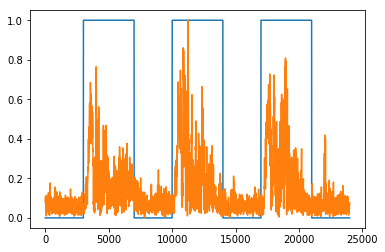

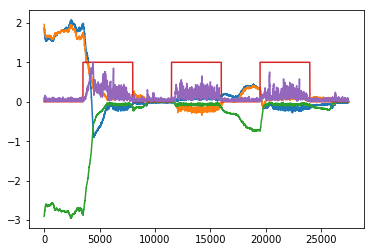

In [4]:
########################################## READ THE DATASETS #######################################################
####################### DATASET 1-2, including slip instances for pillbox object ###################################
inp = sio.loadmat(datafiles1,struct_as_record=True)
f1 = inp['f1'] # 1st optoforce
# f2 = inp['f2'] # 2nd optoforce
l1 = inp['label1'] # corresponding labels
# l2 = inp['label2']
f1d = inp['detail1'] # summary of each dataset 
lmat1 = np.zeros(f1.shape[0]) # material label
print 1,f1.shape, l1.shape, lmat1.shape
################ DATASET 3, including slip instances for several surfaces (see f3d for details) ####################
inp3 = sio.loadmat(datafiles2,struct_as_record=True)
f3 = inp3['f3'] # 1st optoforce
f3 = np.array([fi[0][:,:-1] for fi in f3])[:,np.newaxis]
l31 = inp3['label3_cmd'] # corresponding label from commanded slip (1) or stay (0)
# l32 = inp['label3_vel'] # corresponding measured tip velocity
# l33 = inp['label3_acc'] # corresponding measured tip acceleration
f3d = inp3['detail3'] # summary of each dataset
lmat3 = np.array([1,2,2,2,3,2,4]) # material label, for dataset3
print 2,f3.shape, l31.shape, lmat3.shape
################ DATASET 4, including slip instances for several surfaces (see  for details) ####################
inp4 = sio.loadmat(datafiles3,struct_as_record=True)
f4 = inp4['final'] # optoforce of 2nd finger (data_format: 'experiment phase stay(1)/slip(0) fx fy fz vx vy vz')
l41 = np.array([1-fi[0][:,2][:,np.newaxis] for fi in f4])[:,np.newaxis] # commanded slip or stay
l42 = np.array([np.linalg.norm(fi[0][:,6:],axis=1)/np.max(np.linalg.norm(fi[0][:,6:],axis=1))
                for fi in f4])[:,np.newaxis] # slip or stay extracted from velocity
f4d = inp4['surf_name']
lmat4 = inp4['surf_lab'][:,0]
f4 = np.array([fi[0][:,3:6] for fi in f4])[:,np.newaxis]
print 3,f4.shape, l41.shape, l42.shape, f4d.shape, lmat4.shape
plt.figure(0)
plt.plot(l41[0][0])
plt.hold
plt.plot(l42[0][0])
########################################### MERGE THE DATASETS #####################################################
if dataset == 0: # use both datasets
    f = np.concatenate((f1,f3,f4),axis=0)
    l = np.concatenate((l1,l31,l41),axis=0)
    fd = np.concatenate((f1d,f3d,f4d),axis=0)
    lmat = np.concatenate((lmat1,lmat3,lmat4),axis=0)
elif dataset == 1: # use dataset 1-2
    f = f1
    l = l1
    fd = f1d
    lmat = lmat1
elif dataset == 2:              # use dataset 3
    f = f3
    l = l31
    fd = f3d
    lmat = lmat3
elif dataset == 3:              # use dataset 4
    f = f4
    l = l41
    fd = f4d
    lmat = lmat4
print 4,f.shape,l.shape,lmat.shape
####################################### INDECES for dataset 1-2 ####################################################
# all indeces
ind = range(f.shape[0])
# indexes for rolling
indroll = [16,17,21,22] # during pure stable dataset
# indexes for disturbance
inddist = [12,26]       # ind:12 for pure stable and ind:26 for pure slip dataset 
# indexes for rotation
indrot = [25,31]        # during pure slip dataset
# indexes for circular induced slippage
indcirc = [32,33]       # during pure slip dataset
# kept indeces
if dataset == 0:
    nind = np.delete(ind,indroll+inddist)#+indrot+indcirc)
else:
    nind = range(f.shape[0])
f = f[nind]
l = l[nind]
print 5,f.shape, l.shape
# membership of each sample, representing its portion in the dataset
member = np.zeros(len(f))
m1,m3,m4 = len(nind)-len(f3)-len(f4),len(f3),len(f4)
member[:m1] = np.ones(m1)*1./m1
member[-m3-m4:-m4] = np.ones(m3)*1./m3
member[-m4:] = np.ones(m4)*1./m4
print 6,sum(member[:m1]),sum(member[-m3-m4:-m4]),sum(member[-m4:]),
########################################### MERGE f and l ##########################################################
f = np.array([np.concatenate((f[i,0],l[i,0]),axis=1) for i in range(len(f))])
print 7,f.shape,":",[fi.shape for fi in f]
plt.figure(1)
plt.plot(f[-1])
plt.hold
plt.plot(l42[-1,0])

In [5]:
def ftran(f,history=20):
# Rotation of measured force wrt to contact normal frame
# Estimation of normal force at contact point assuming f
# is very close to the middle of the friction cone
    l = f[history:,-1]
    f = f[:,:-1]
    nfo = np.zeros(f[history:,:].shape)
    z = np.array([0, 0, 1])
    lastnfo = z
    currnfo = z
    retf = np.zeros(f[history:,:].shape)
#     nfo = [np.mean(f[i-history:i,:],axis=1) for i in range(len(f)) if sum(l[i-history:i]) == 0 and i>=history]  
    for i in range(len(f)):
        if i>=history:
#             print l.shape
#             print np.sum(l[i-history:i])
            if np.sum(l[i-history:i]) == 0:
                currnfo = np.mean(f[i-history:i,:],axis=0)
#                 print currnfo.shape
                currnfo /= np.linalg.norm(currnfo)
                lastnfo = currnfo
            else:
                currnfo = lastnfo
            nfo[i-history] = currnfo

            if sum(currnfo == z) == 3 or sum(currnfo == -z) == 3:
                R_cb = np.eye(3)
            else:
                R_cb = np.zeros((3, 3))
                R_cb[:, 2] = currnfo
                R_cb[:, 0] = np.cross(currnfo, z)  # x' = nfo x z
                R_cb[:, 0] = R_cb[:, 0]*1./np.sqrt(sum(np.power(R_cb[:, 0], 2)))
                R_cb[:, 1] = np.cross(currnfo, R_cb[:, 0])  # y' = nfo x x'
            R_bc = R_cb.transpose()
            newf = R_bc.dot(f[i,:])  # newf wrt contact normal's frame
            retf[i-history,:] = newf
    retf = np.concatenate((retf,l[:,np.newaxis]),axis=1)
    nfo = np.concatenate((nfo,l[:,np.newaxis]),axis=1)
    return retf, nfo

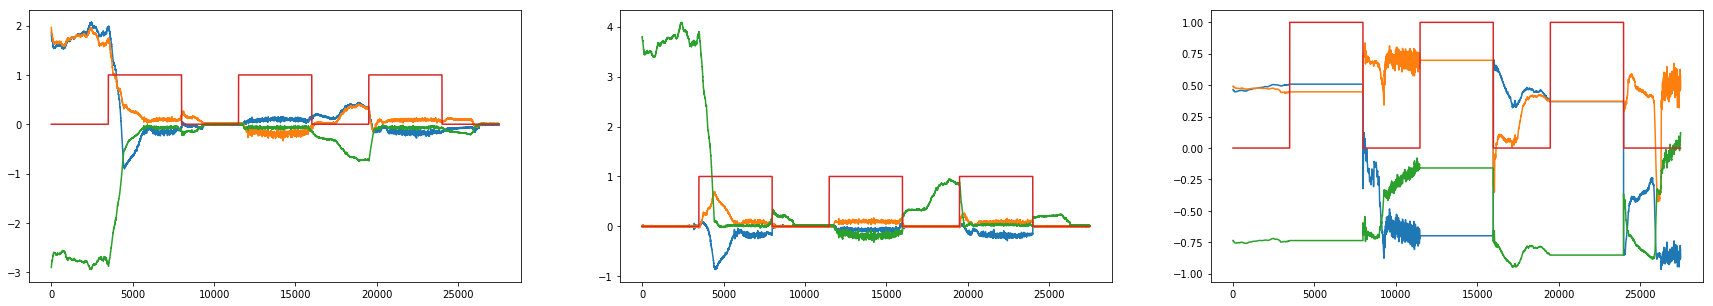

In [6]:
i = len(f)
plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
plt.plot(f[-1])
plt.subplot(1,3,2)
plt.plot(ftran(f[-1])[0])
plt.subplot(1,3,3)
plt.plot(ftran(f[-1])[1])

In [7]:
########################################### PRE-FEATURES ###########################################################
############# DEFINITION
# featnum 0 : sf    = (fx^2+fy^2+fz^2)^0.5
#         1 : ft    = (fx^2+fy^2)^0.5
#         2 : fn    = |fz|
#         3 : ft/fn = (fx^2+fy^2)^0.5/|fz|
# input (nxm) -> keep (nx3) -> compute pre-feature and return (nx1)
# def fnormal(f,l):
#     return 0
# def ftranslate(f,fn):
#     return 0
def sf(f):
    return np.power(np.sum(np.power(f[:,:3],2),axis=1),0.5)
def ft(f):
    return np.power(np.sum(np.power(f[:,:2],2),axis=1),0.5)
def fn(f):
    return np.abs(f[:,2])
def ftn(f):
    retft = ft(f)
    retfn = fn(f)
    retft[retfn<=1e-3] = 0
    return np.divide(retft,retfn+np.finfo(float).eps)
def lab(f):
    return np.abs(f[:,-1])
prefeatfn = np.array([sf,ft,fn,ftn,lab]) # convert to np.array to be easily indexed by a list
############# COMPUTATION
prefeatname = 'newprefeatures_trans'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
prefeatfile = featpath+prefeatname+'.npz'
# prefeat = np.array([np.array([f[i] for prfn in prefeatfn[prefeatid]]) for i in range(len(f))])
prefeat = np.array([np.array([prfn(f[i]) for prfn in prefeatfn[prefeatid]]).transpose() for i in range(len(f))])
print prefeat.shape,":",[p.shape for p in prefeat]
# newprefeat = np.array([np.array([ftran(f[i],l[i][0]) for prfn in prefeatfn[prefeatid]]) for i in range(len(f))])
if os.path.isfile(prefeatfile):
    newprefeat = np.load(prefeatfile)['newprefeat']
else:
    newprefeat = np.array([np.array([prfn(ftran(f[i])[0]) for prfn in prefeatfn[prefeatid]]).transpose() for i in range(len(f))])
    np.savez(prefeatfile,newprefeat=newprefeat)
# newprefeat = np.array([Parallel(n_jobs=-1)([delayed(function)(orisma)(np.array([prfn(ftran(f[i],l[i][0])) for prfn in prefeatfn[prefeatid]]).transpose()) for i in range(len(f))])])
# np.array([Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])])
print newprefeat.shape,":",[p.shape for p in newprefeat]

(50,) : [(2498, 3), (2498, 3), (2496, 3), (2484, 3), (4094, 3), (5747, 3), (6169, 3), (5163, 3), (6280, 3), (10019, 3), (12642, 3), (5769, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (2460, 3), (40018, 3), (39994, 3), (40004, 3), (39852, 3), (39946, 3), (31082, 3), (39896, 3), (24000, 3), (21000, 3), (20500, 3), (20500, 3), (23500, 3), (24000, 3), (24000, 3), (24000, 3), (24000, 3), (24000, 3), (24000, 3), (27000, 3), (27500, 3), (27500, 3), (27500, 3)]
(50,) : [(2478, 3), (2478, 3), (2476, 3), (2464, 3), (4074, 3), (5727, 3), (6149, 3), (5143, 3), (6260, 3), (9999, 3), (12622, 3), (5749, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (39998, 3), (39974, 3), (39984, 3), (39832, 3), (39926, 3), (31062, 3), (39876, 3), (23980, 3), (20

(27500, 3) (27480, 3)


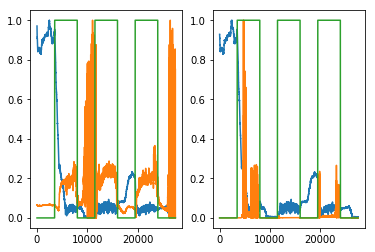

In [8]:
print prefeat[-1].shape, newprefeat[-1].shape
plt.subplot(1,2,1)
plt.plot(prefeat[-1]/np.max(prefeat[-1],axis=0))
plt.subplot(1,2,2)
plt.plot(newprefeat[-1]/np.max(newprefeat[-1],axis=0))

(50,) : [(2478, 3), (2478, 3), (2476, 3), (2464, 3), (4074, 3), (5727, 3), (6149, 3), (5143, 3), (6260, 3), (9999, 3), (12622, 3), (5749, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (2440, 3), (39998, 3), (39974, 3), (39984, 3), (39832, 3), (39926, 3), (31062, 3), (39876, 3), (23980, 3), (20980, 3), (20480, 3), (20480, 3), (23480, 3), (23980, 3), (23980, 3), (23980, 3), (23980, 3), (23980, 3), (23980, 3), (26980, 3), (27480, 3), (27480, 3), (27480, 3)]


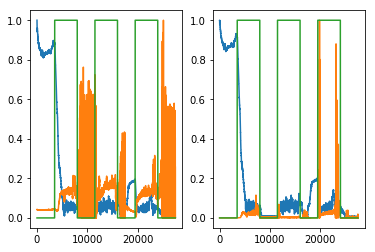

In [9]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(prefeat[-2]/np.max(prefeat[-2],axis=0))
plt.subplot(1,2,2)
plt.plot(newprefeat[-2]/np.max(newprefeat[-2],axis=0))
prefeat = newprefeat
print prefeat.shape,":",[p.shape for p in prefeat]

In [10]:
############################################# FEATURE COMPUTATION ##################################################
# featname = 'newfeatures'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
featname = 'newfeatures_trans'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
featfile = featpath+featname+'.npz'
XYfile = featpath+featname+'_XY.npz'
XYnormfile = featpath+featname+'_XYnorm.npz'
# def tmpfeatfilename(p,mode='all'):
#     if mode == 'all':
#         return featpath+'allfeats/'+'feat'+str(p)+'.pkl.z'
#     elif mode == 'red':
#         return featpath+'allfeats/'+'feat'+str(p)+'red'+str(samplesperdataset)+'.pkl.z'
def tmpfeatfilename(p,mode='all'):
    if mode == 'all':
        return featpath+'allfeats/'+'feat_tran'+str(p)+'.pkl.z'
    elif mode == 'red':
        return featpath+'allfeats/'+'feat_tran'+str(p)+'red'+str(samplesperdataset)+'.pkl.z'
if os.path.isfile(XYfile):
    print "Continuing to XY values..."
else:
    if os.path.isfile(featfile):
        start_time = time.time()
        features = np.load(featfile)['features']
        labels = np.load(featfile)['labels']
        print("Features FOUND PRECOMPUTED! Feature Loading DONE in: %s seconds " % (time.time() - start_time))
    else:
        start_time = time.time()
        features = []
        labels = []
        for ixp in range(len(prefeat)):
            p = prefeat[ixp]
            now = time.time()
            tmpfn = tmpfeatfilename(ixp)
            tmpfnred = tmpfeatfilename(ixp,'red')
            if not os.path.isfile(tmpfnred):
                if not os.path.isfile(tmpfn):
                    # Computation of all features in parallel by all cores
                    tmp = np.array([Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])])
                    with open(tmpfn,'wb') as fo:
                        joblib.dump(tmp,fo)
                    print ixp, time.time()-now, tmpfn, tmp.shape
                else:
                    with open(tmpfn,'rb') as fo:
                        tmp = joblib.load(fo)
                    print ixp, time.time()-now, tmpfn, ' already here!', tmp.shape
                # keep less from each feature vector but keep number of samples for each dataset almost equal
                #tmpskip = int(round(tmp.shape[1]/200.))
                tmpskip = int(round(tmp.shape[1]/(member[ixp]*samplesperdataset)))
                # Save reduced size features
                tmp = tmp[0,::tmpskip,:,:]
                with open(tmpfnred,'wb') as fo:
                    joblib.dump(tmp,fo)
                print ixp, time.time()-now, tmpfnred, tmp.shape
        for ixp in range(len(prefeat)):  
            tmpfnred = tmpfeatfilename(ixp,'red')
            with open(tmpfnred,'rb') as fo:
                tmp = joblib.load(fo)
            print ixp, time.time()-now, tmpfnred, 'already here!', tmp.shape
            features.append(tmp[:,:,:2])
            labels.append(tmp[:,0,2])
            #features.append(tmp[0,::tmpskip,:,:2])
            #labels.append(tmp[0,::tmpskip,0,2])
            #print np.array(features.shape), np.array(labels.shape)
            #print 'features: ',np.array(features).shape,[f.shape for f in features]
            #print 'labels: ', np.array(labels).shape,[l.shape for l in labels]
        #allfeatures = [Parallel(n_jobs=4)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)]) for p in prefeat[:-7]]
        #allfeatures = [[feat(p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)] for p in prefeat[:-7]]
        #allfeatures = [[feat(p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)] for p in prefeat[-7:]]
        #print 'allfeatures: ',allfeatures.shape
        print("Features NOT FOUND PRECOMPUTED! Feature Computation DONE in: %s seconds " % (time.time() - start_time))
        #raw_input()
        #features = np.array([np.array(fi)[:,:,:-1] for fi in allfeatures])
        #labels = np.array([np.array(fi)[:,0,-1] for fi in allfeatures])
        features = np.array(features)
        labels = np.array(labels)
        print 'features: ',features.shape,[f.shape for f in features]
        print 'labels: ', labels.shape,[l.shape for l in labels]
        #print("Features NOT FOUND PRECOMPUTED! Feature Computation DONE in: %s seconds " % (time.time() - start_time))
        np.savez(featfile,features=features,labels=labels)
        #sio.savemat(featpath+featname+'.mat',mdict={'features': features,'labels': labels})
    print features.shape, labels.shape
    for i in range(features.shape[0]):
        print i, np.array(features[i]).shape, np.array(labels[i]).shape

Continuing to XY values...


In [11]:
############################# GATHER ALL FEATURES TOGETHER and NORMALIZE THEM ######################################
############# GATHERING features and labels into one array each
if os.path.isfile(XYfile):
    print "Continuing to XY values..."
else:
    #features = features[:,::keepfromshift,:]
    #labels = labels[:,::keepfromshift,:]
    ind,feats = {},{}
    l_ind = [0,0,0]
    ind[2] = range(features.shape[0])                                      # indeces for all datasets
#     print features.shape, len(ind[2]), int(round(len(ind[2])*1./samplesperdataset))
#     ind[2] = ind[2][::int(round(len(ind[2])*1./samplesperdataset))]
    ind[0] = range(features.shape[0])[:m1+m3]                                 # indeces for pillbox dataset12
#     ind[0] = ind[0][::int(round(len(ind[0])*1./samplesperdataset))]
    ind[1] = range(features.shape[0])[-m4:]                          # indeces or different surfaces dataset3
#     ind[1] = ind[1][::int(round(len(ind[1])*1./samplesperdataset))]
    ind = np.array([i for _,i in ind.items()])
    feats[0] = features[ind[0]]                                              # features for pillbox
    feats[1] = features[ind[1]]
    feats[2] = features[ind[2]]                                            # features for differ. surfaces
    print 'prefeats: ',feats[0].shape, feats[1].shape, feats[2].shape
#     feats[2] = np.concatenate(features,axis=0)                                # all features together
    feats[2] = np.concatenate(feats[2],axis=0)
    print feats[2].shape[0]#,int(round(feats[2].shape[0]*1./samplesperdataset))
    l_ind[2] = feats[2].shape[0]
    feats[2] = np.array([feats[2][:,:,i] for i in range(feats[2].shape[2])])
    feats[2] = feats[2][:,::int(round(feats[2].shape[1]*1./samplesperdataset)),:]
    print feats[2].shape
    feats[0] = np.concatenate(feats[0],axis=0)
    print feats[0].shape[0]#,int(round(feats[0].shape[0]*1./samplesperdataset))
    l_ind[0] = feats[0].shape[0]
    feats[0] = np.array([feats[0][:,:,i] for i in range(feats[0].shape[2])])
    feats[0] = feats[0][:,::int(round(feats[0].shape[1]*1./samplesperdataset)),:]
    print feats[0].shape
    feats[1] = np.concatenate(feats[1],axis=0)
    print feats[1].shape[0]#,int(round(feats[1].shape[0]*1./samplesperdataset))
    l_ind[1] = feats[1].shape[0]
    feats[1] = np.array([feats[1][:,:,i] for i in range(feats[1].shape[2])])
    feats[1] = feats[1][:,::int(round(feats[1].shape[1]*1./samplesperdataset)),:]
    print feats[1].shape
    feats = [i for _,i in feats.items()]
    print 'feats: ',feats[0].shape, feats[1].shape, feats[2].shape
    labs = np.concatenate(labels,axis=0)
    print 'labs: ',labs.shape

Continuing to XY values...


In [12]:
############# GATHERING into one complete array
if os.path.isfile(XYfile):
    X = np.load(XYfile)['X']
    Y = np.load(XYfile)['Y']
else:
    X,Y = {},{}
#     ind[2] = np.array(range(feats[0].shape[1]+feats[1].shape[1],feats[0].shape[1]+feats[1].shape[1]+feats[2].shape[1]))
#     ind[2] = np.array(range(feats[2].shape[1]))
    ind[2] = np.array(range(l_ind[2]))
    ind[2] = ind[2][::int(round(len(ind[2])*1./samplesperdataset))]
    ind[0] = np.array(range(l_ind[0]))                               # indeces for pillbox dataset12
    ind[0] = ind[0][::int(round(len(ind[0])*1./samplesperdataset))]
    ind[1] = np.array(range(l_ind[0],l_ind[0]+l_ind[1]))
    ind[1] = ind[1][::int(round(len(ind[1])*1./samplesperdataset))]
    print ind[0].shape, ind[1].shape, ind[2].shape
#     raw_input()
    X[2],Y[2] = np.concatenate([feats[2][i] for i in range(feats[2].shape[0])],axis=1),labs[ind[2]]
    X[0],Y[0] = np.concatenate([feats[0][i] for i in range(feats[0].shape[0])],axis=1),labs[ind[0]]
    X[1],Y[1] = np.concatenate([feats[1][i] for i in range(feats[1].shape[0])],axis=1),labs[ind[1]]
    X = np.array([i for _,i in X.items()])
    Y = np.array([i for _,i in Y.items()])
    np.savez(XYfile,X=X,Y=Y)
print 'gathered features: ', X[0].shape, Y[0].shape, X[1].shape, Y[1].shape, X[2].shape, Y[2].shape, np.sum(Y[2])

gathered features:  (19665, 6216) (19665,) (20041, 6216) (20041,) (19791, 6216) (19791,) 9649.0


In [13]:
################################################## NORMALIZATION ###################################################
# normalize by abstracting mean and dividing by std
tmpind = {}
tmpind[2] = range(X[0].shape[1])
tmpind[0] = range(X[0].shape[1]/2)
tmpind[1] = range(X[0].shape[1]/2,X[0].shape[1])
tmpind = np.array([i for _,i in tmpind.items()])
if os.path.isfile(XYnormfile):
    X = np.load(XYnormfile)['Xs']
    S = np.load(XYnormfile)['S']
    # X = np.load(XYfile)['Xn']
    # N = np.load(XYfile)['N']
else:
    Xn,S,N = {},{},{}
    for i in range(len(X)): # for all datasets
        S[i],N[i] = {},{}
        for j in range(len(tmpind)): # for all features
            S[i][j] = StandardScaler().fit(X[i][:,tmpind[j]])
            #N[i][j] = MinMaxScaler().fit(X[i][:,tmpind[j]])
        X[i] = S[i][len(tmpind)-1].transform(X[i])
        #Xn[i] = N[i][len(tmpind)-1].transform(X[i])
    S = np.array([[Sij for _,Sij in Si.items()] for _,Si in S.items()])
    #N = np.array([[Nij for _,Nij in Ni.items()] for _,Ni in N.items()])
    #Xn = np.array([i for _,i in Xn.items()])
    #np.savez(XYnormfile,Xs=X,Xn=Xn,S=S,N=N)
    np.savez(XYnormfile,Xs=X,S=S)
print 'normalized features: ', X[0].shape, X[1].shape, X[2].shape

normalized features:  (19665, 6216) (20041, 6216) (19791, 6216)


In [14]:
########################################## Feature Names ###########################################################
####################################################################################################################
##  features:                                                                                  ||      if         ##
##  |----------> time domain      :                                                            || samples = 1024  ##
##  |------------|---> phinyomark : 11+3{shist} -----------------------------> = 14+0.0samples ||             14  ##
##  |------------|---> golz       : 10+samples{acrol} -----------------------> = 10+1.0samples ||           1034  ##
##  |----------> frequency domain :                                                                               ##
##  |------------|---> phinyomark : 3{arco}+4{mf}+3(samples/2+1){RF,IF} -----> =  9+1.0samples ||           1033  ##
##  |------------|---> golz       : 1{ffaf}+2(samples/2+1){AF,PF} -----------> =  3+1.0samples ||           1027  ##
##  |------------|--------|-------alltogether--------------------------------> = 36+3.5samples || numfeat = 3108  ##
####################################################################################################################
## Time Domain Phinyomark feats
featnames = ['intsgnl', 'meanabs', 'meanabsslp', 'ssi', 'var', 'rms', 'rng', 'wavl', 'zerox', 'ssc', 'wamp', 
             'shist1', 'shist2', 'shist3']                                                   # 11+3{shist}
## Frequency Domain Phinyomark feats
featnames += ['arco1', 'arco2', 'arco3', 'mnf', 'mdf', 'mmnf', 'mmdf']                       # 3{arco}+4{mf}
featnames += ['reFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{RF}
featnames += ['imFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{IF}
## Time Domain Golz feats
featnames += ['meanv', 'stdr', 'mx', 'rngx', 'rngy', 'med', 'hjorth', 'sentr', 'se', 'ssk']  # 10
featnames += ['acrol{:04d}'.format(i) for i in range(window)]                                # samples{acrol}
## Frequency Domain Golz feats
featnames += ['amFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{AF}
featnames += ['phFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{PF}
featnames += ['ffaf']                                                                        # 1{ffaf}

In [15]:
######################################## FEATURE SELECTION #########################################################
# feature names
# numfeat = 10 # number of features to show
# nfeat = 1000 # number of features to keep
#namesid = ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i) for i in range(X[0].shape[1])]
namesid = [['sf{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
           ['ftn{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
           ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i%X[0].shape[1]/2) for i in range(X[0].shape[1])]]
namesf = [['sf_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
         ['ftn_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
         ['sf_{}'.format(featnames[i]) if i<X[0].shape[1]/2 else 'ftn_{}'.format(featnames[i%X[0].shape[1]/2]) for i in range(X[0].shape[1])]]
########## use RandomizedLasso of MutualInfo as the model to select features and find their importances ############
featselfile = featpath+featname+'_featselall'+'.npz'
tmpind1 = {}
tmpind1[2] = range(X[2].shape[0])
tmpind1[0] = range(X[0].shape[0])
tmpind1[1] = range(X[1].shape[0])
tmpind1 = np.array([i for _,i in tmpind1.items()])
tmpskip = [int(len(tmpind1[i])/3000) for i in range(len(tmpind1))]
print tmpskip
#tmpskip = [1 for i in range(3)]
start_time = time.time()
if os.path.isfile(featselfile):
    #rlasso = np.load(featselfile)['rlasso'].tolist()
    featsel = np.load(featselfile)['featsel'].tolist()
    print("Selected Features FOUND PRECOMPUTED! Loading DONE in: %s seconds " % (time.time() - start_time))
else:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UserWarning)
        warnings.simplefilter('ignore', ConvergenceWarning)
        # loop for all datasets (12,3,all) and all features (sf,ftn,all)
        #featsel = [[RandomizedLasso(fit_intercept=False,normalize=False).fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
        #Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])
        featsel = [Parallel(n_jobs=-1)([delayed(SelectKBest(mutual_info_classif,'all').fit) 
                    (X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]])
                    for i,j in itertools.product(range(len(X)),range(3))])]
        featsel = np.array([[featsel[0][i*len(range(3))+j] for j in range(3)] for i in range(len(X))])
                   #for j in range(3) for i in range(len(X))]
#         featsel = [[SelectKBest(mutual_info_classif,'all').fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
#                     for j in range(3)] for i in range(len(X))]
        print("Selected Features NOT FOUND PRECOMPUTED! Selection DONE in: %s seconds " % (time.time() - start_time))
        #np.savez(featselfile,rlasso=np.array(rlasso))
        np.savez(featselfile,featsel=featsel)
# rank features
print "----> Features sorted by their rank (std norm):"
bestix = {}
wrstix = {}
for i in range(len(X)): # for all diff data sets
    bestix[i] = {}
    wrstix[i] = {}
    for j in range(3): # for all diff feature sets
        tmp = sorted(zip(map(lambda x: round(x,4), featsel[i][j].scores_),namesf[j]),reverse=True)
        bestix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::-1]
        #wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:nfeat][::1]
        wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::1]
        print 'Best '+str(numfeat)+': ',tmp[:numfeat], bestix[i][j].shape, bestix[i][j][:numfeat]
        print 'Worst '+str(numfeat)+': ',tmp[-numfeat:], wrstix[i][j].shape, wrstix[i][j][:numfeat]
bestix = np.array([[ij for _,ij in i.items()] for _,i in bestix.items()])
wrstix = np.array([[ij for _,ij in i.items()] for _,i in wrstix.items()])
# print "----> Features sorted by their rank (minmax norm):"
# print sorted(zip(map(lambda x: round(x,4), rlasso2.scores_),names),reverse=True)[:numfeat]

[6, 6, 6]
Selected Features FOUND PRECOMPUTED! Loading DONE in: 0.0238080024719 seconds 
----> Features sorted by their rank (std norm):
Best 10:  [(0.3675, 'sf_mx'), (0.3215, 'sf_rng'), (0.3211, 'sf_rngy'), (0.2982, 'sf_med'), (0.2858, 'sf_acrol0840'), (0.2846, 'sf_acrol0841'), (0.2835, 'sf_wavl'), (0.2834, 'sf_acrol0954'), (0.283, 'sf_acrol0959'), (0.2829, 'sf_acrol0953')] (3108,) [1049    6 1051 1052 1897 1898    7 2011 2016 2010]
Worst 10:  [(0.0476, 'sf_phFFT115'), (0.044, 'sf_shist1'), (0.0412, 'sf_imFFT505'), (0.0408, 'sf_imFFT509'), (0.0362, 'sf_arco2'), (0.0339, 'sf_sentr'), (0.0074, 'sf_imFFT512'), (0.0009, 'sf_zerox'), (0.0001, 'sf_rngx'), (0.0, 'sf_imFFT000')] (3108,) [ 534 1050    8 1046 1054   15 1043 1039   11 2709]
Best 10:  [(0.5244, 'ftn_mx'), (0.5016, 'ftn_acrol1004'), (0.5013, 'ftn_acrol1003'), (0.499, 'ftn_acrol0997'), (0.4974, 'ftn_acrol1007'), (0.4972, 'ftn_acrol1011'), (0.4972, 'ftn_acrol1000'), (0.4964, 'ftn_acrol1015'), (0.4963, 'ftn_acrol0980'), (0.4959, 'ftn

In [17]:
# fig = plt.figure(figsize=(30,90))
# r, c = np.array(X).shape[0], tmpind.shape[0]
# matplotlib.rcParams['text.usetex'] = True
# for i in range(r):
#     for j in range(c):
#         ax = fig.add_subplot(r*c,1,i*c+j+1)
#         tmp = X[i][:-1:tmpskip[i],tmpind[j]]
#         tmprng = np.max(tmp,axis=0)-np.min(tmp,axis=0)
#         tmp -= np.min(tmp,axis=0)
#         tmp /= tmprng+np.finfo(float).eps
# #         ax.plot(X[i][:-1:tmpskip[i],tmpind[j]]/(np.max(X[i][:-1:tmpskip[i],tmpind[j]],axis=0)+np.finfo(float).eps))
#         ax.plot(tmp)
#         ax.hold
#         ax.plot(Y[i][:-1:tmpskip[i]])
#         if i==0 and j==0:
#             ax.set_title(r'$\zeta_1=\sigma(|f|)$')
#             ax.set_ylabel(r'$d_1$')
#         if i==0 and j==1:
#             ax.set_title(r'$\zeta_2=\sigma(|f_t/f_n|)$')
#         if i==0 and j==2:
#             ax.set_title(r'$\zeta_3=\zeta_1\bigcup \zeta_2$')
#         if i==1 and j==0:
#             ax.set_ylabel(r'$d_2$')
#         if i==2 and j==0:
#             ax.set_ylabel(r'$d_3=d_1\bigcup d_2$')
#         if i==2:
#             ax.set_xlabel('features')

# i = 0
# plt.plot(X[i][:-1:tmpskip[i],tmpind[j]]/(np.linalg.norm(X[i][:-1:tmpskip[i],tmpind[j]],axis=0)+np.finfo(float).eps))
# plt.hold
# plt.plot(Y[i][:-1:tmpskip[i]])

In [18]:
################################ BEST and WORST FEATURES for each dataset and feature pair #########################
for i in range(len(X)): # for all diff data sets
    for j in range(3): # for all diff feature sets
        tmpfsz = np.array(namesf[j]).shape[0]
        print np.array([namesf[j][bestix[i][j][k]] for k in range(tmpfsz)]).shape
        tmpb = list(OrderedDict.fromkeys([re.sub('[^a-zA-Z]','',namesf[j][bestix[i][j][k]]) for k in range(tmpfsz)]))
        #tmpb = list(OrderedDict.fromkeys([filter(str.isdigit,namesf[j][bestix[i][j][k]]) for k in range(tmpfsz)]))
        tmpw = list(OrderedDict.fromkeys([filter(str.isalpha,namesf[j][wrstix[i][j][k]]) for k in range(tmpfsz)]))
        print '----------------------------------------------------------------------------------------------------'
        print 'Features for ',i,j,' sorted: ',tmpb,np.array(tmpb).shape
        print 'Features for ',i,j,' sorted: ',tmpw[::-1],np.array(tmpw).shape,tmpfsz

(3108,)
----------------------------------------------------------------------------------------------------
Features for  0 0  sorted:  ['sfmx', 'sfrng', 'sfrngy', 'sfmed', 'sfacrol', 'sfwavl', 'sfmeanv', 'sfreFFT', 'sfmeanabs', 'sfamFFT', 'sfintsgnl', 'sfphFFT', 'sfvar', 'sfrms', 'sfse', 'sfssi', 'sfimFFT', 'sfstdr', 'sfmeanabsslp', 'sfmmnf', 'sfwamp', 'sfmnf', 'sfssc', 'sfmdf', 'sfarco', 'sfmmdf', 'sfhjorth', 'sfssk', 'sfshist', 'sfffaf', 'sfsentr', 'sfzerox', 'sfrngx'] (33,)
Features for  0 0  sorted:  ['sfmx', 'sfrng', 'sfrngy', 'sfmed', 'sfwavl', 'sfmeanv', 'sfmeanabs', 'sfintsgnl', 'sfvar', 'sfrms', 'sfse', 'sfssi', 'sfacrol', 'sfstdr', 'sfmeanabsslp', 'sfmmnf', 'sfwamp', 'sfmnf', 'sfssc', 'sfmdf', 'sfmmdf', 'sfhjorth', 'sfssk', 'sfffaf', 'sfreFFT', 'sfamFFT', 'sfphFFT', 'sfshist', 'sfarco', 'sfsentr', 'sfzerox', 'sfrngx', 'sfimFFT'] (33,) 3108
(3108,)
----------------------------------------------------------------------------------------------------
Features for  0 1  sorted: 

(19665, 1000)
(19665, 1000)
(19665, 1000)
(20041, 1000)
(20041, 1000)
(20041, 1000)
(19791, 1000)
(19791, 1000)
(19791, 1000)


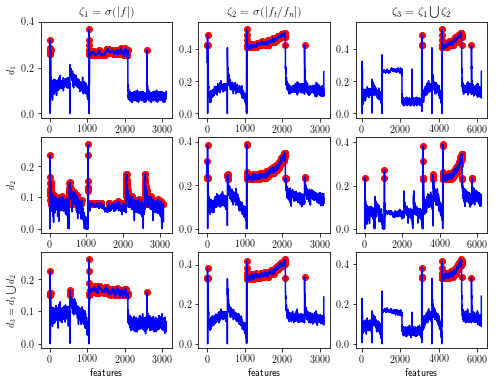

In [19]:
############################### DIMENSIONALITY REDUCTION VIA FEATURE SELECTION #####################################
fig = plt.figure(figsize=(8,6))
r,c = np.array(featsel).shape[0],np.array(featsel).shape[1]
Xfs = {}
matplotlib.rcParams['text.usetex'] = True
for i in range(r):
    Xfs[i] = {}
    for j in range(c):
        Xfs[i][j] = np.array(featsel[i][j].transform(X[i][:,tmpind[j]]))[:,bestix[i][j][:nfeat]]
        print Xfs[i][j].shape
        ax = fig.add_subplot(r,c,i*c+j+1)
        ax.plot(featsel[i][j].scores_,'b')
        ax.scatter(bestix[i][j][:nfeat],featsel[i][j].scores_[bestix[i][j][:nfeat]],color='r')
        if i==0 and j==0:
            ax.set_title(r'$\zeta_1=\sigma(|f|)$')
            ax.set_ylabel(r'$d_1$')
        if i==0 and j==1:
            ax.set_title(r'$\zeta_2=\sigma(|f_t/f_n|)$')
        if i==0 and j==2:
            ax.set_title(r'$\zeta_3=\zeta_1\bigcup \zeta_2$')
        if i==1 and j==0:
            ax.set_ylabel(r'$d_2$')
        if i==2 and j==0:
            ax.set_ylabel(r'$d_3=d_1\bigcup d_2$')
        if i==2:
            ax.set_xlabel('features')
Xfs = np.array([[i for _,i in Xfsi.items()] for _,Xfsi in Xfs.items()])
#plt.show()
savefig('plots/'+featname+'_featsel.png', bbox_inches='tight')
savefig('plots/featureselection.eps',format='eps',dpi=50,bbox_inches='tight')

In [20]:
############################# Computation time of ALL features in secs #############################################
t1 = time.time()
tmpfeat = [feat(prefeat[30][i:i+window,:2],*featparam) for i in range(100)] # avg over 100 times
print (time.time()-t1)/100

0.0176084303856


(1967, 20) (1967,) [  9.95821446e-01   2.04486229e-03   1.15824494e-03   7.27733584e-04
   2.24391338e-04   1.52817500e-05   2.98564549e-06   2.63452906e-06
   1.23423801e-06   5.11877255e-07   2.35195021e-07   1.24111123e-07
   9.53404633e-08   7.57239850e-08   5.36477398e-08   2.54082508e-08
   1.52595115e-08   1.14041611e-08   1.05562992e-08   6.52461633e-09]
(1967, 20) (1967,) [  9.24469595e-01   4.81690921e-02   1.83061216e-02   6.55453938e-03
   1.35145747e-03   7.80684117e-04   2.91722568e-04   5.31788026e-05
   1.81425138e-05   2.73905868e-06   1.54932611e-06   7.48513259e-07
   1.86191869e-07   1.18853129e-07   6.22838185e-08   2.20406120e-08
   1.98524027e-08   1.11559981e-08   2.74748934e-09   2.26914296e-09]
(1967, 20) (1967,) [  9.24487423e-01   4.81953108e-02   1.82735486e-02   6.53502715e-03
   1.36135620e-03   7.77428844e-04   2.92763232e-04   5.34584126e-05
   1.82044998e-05   2.74618826e-06   1.55135079e-06   7.50061480e-07
   1.86310502e-07   1.18828981e-07   6.27377

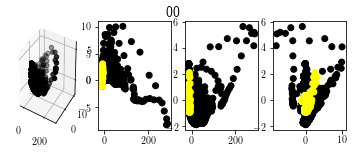

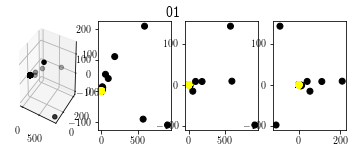

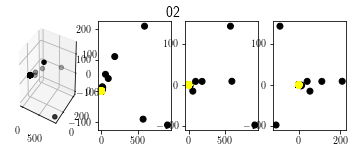

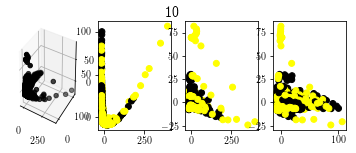

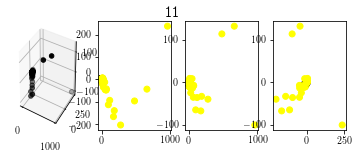

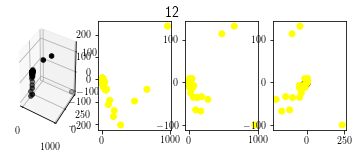

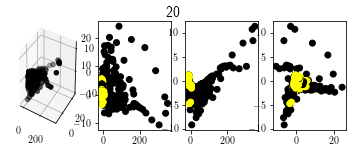

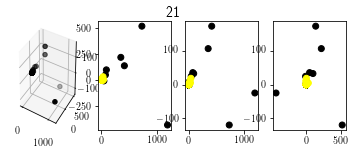

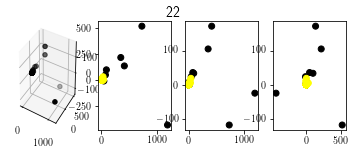

In [21]:
################################### DIMENSIONALITY REDUCTION #######################################################
featdimredfile = featpath+featname+'_dimred'+'.npz'
ncomp = 20
tmpskip = 10
if os.path.isfile(featdimredfile):
    inpdimred = np.load(featdimredfile)
    pca = inpdimred['pca'].tolist()
    Xpca = inpdimred['Xpca']
    tmpix = inpdimred['tmpix']
else:
    # PCA
    r,c = Xfs.shape[0],Xfs.shape[1]
    Xpca,pca,tmpix = {},{},{}
    for i in range(r):
        Xpca[i],pca[i] = {},{}
        tmpix[i] = range(0,Xfs[i][0].shape[0],tmpskip)
        for j in range(c):
            pca[i][j] = PCA(n_components=ncomp, random_state=0)
            pca[i][j].fit(Xfs[i][j][tmpix[i],:])
            Xpca[i][j] = pca[i][j].transform(Xfs[i][j][tmpix[i],:])
    pca = np.array([[i for _,i in pcai.items()] for _,pcai in pca.items()])
    Xpca = np.array([[i for _,i in Xpcai.items()] for _,Xpcai in Xpca.items()])
    tmpix = np.array([i for _,i  in tmpix.items()])
    np.savez(featdimredfile,pca=pca,Xpca=Xpca,tmpix=tmpix)
for i in range(r):
    for j in range(c):
        print Xpca[i][j].shape, np.array(tmpix[i]).shape ,(pca[i][j].explained_variance_ratio_)
        ################################## VISUALIZATION OF DIMENSIONALITY REDUCTION ###############################
        fig = plt.figure(figsize=(6,2))
        fig.suptitle(str(i)+str(j), fontsize=14, fontweight='bold')
        #ax = Axes3D(fig)
        #fig = plt.figure()
        #ax = fig.add_subplot(111, projection='3d')
        ax = fig.add_subplot(141, projection='3d')
        #ax = fig.add_subplot(141)
        ax.scatter(Xpca[i][j][:,0],Xpca[i][j][:,1],Xpca[i][j][:,2],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))
        ax = fig.add_subplot(142)
        ax.scatter(Xpca[i][j][:,0],Xpca[i][j][:,1],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))
        ax = fig.add_subplot(143)
        ax.scatter(Xpca[i][j][:,0],Xpca[i][j][:,2],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))
        ax = fig.add_subplot(144)
        ax.scatter(Xpca[i][j][:,1],Xpca[i][j][:,2],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))

(9, 2)
Dataset size and plots of 2 first X1 cols and Y1
(1967, 20) (1967,)
(2005, 20) (2005,)
(1980, 20) (1980,)
(1967, 20) (1967,)
(2005, 20) (2005,)
(1980, 20) (1980,)
(1967, 20) (1967,)
(2005, 20) (2005,)
(1980, 20) (1980,)


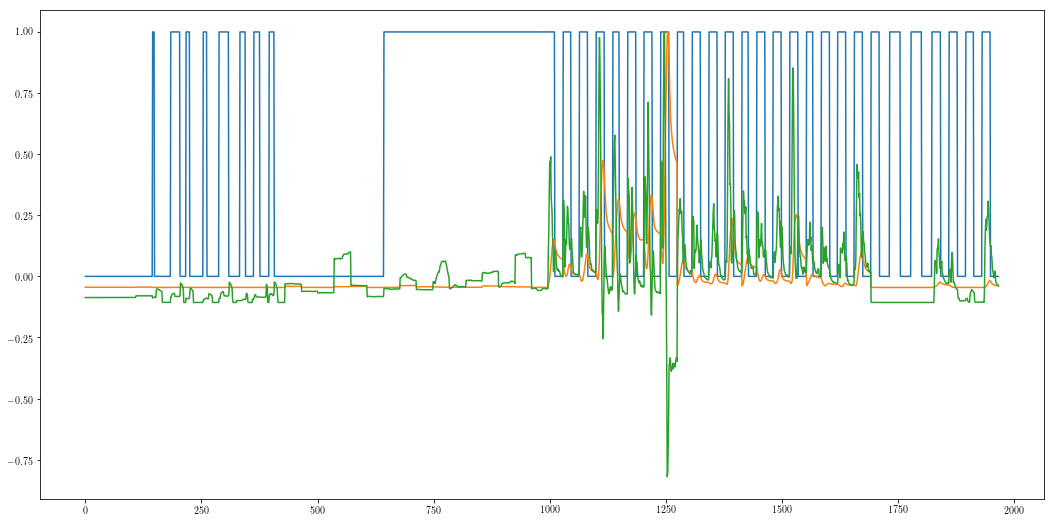

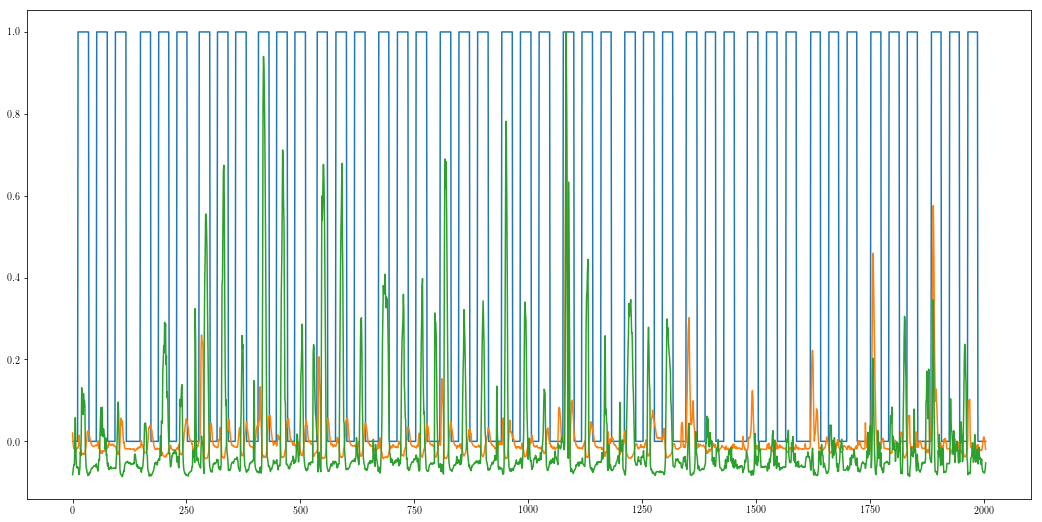

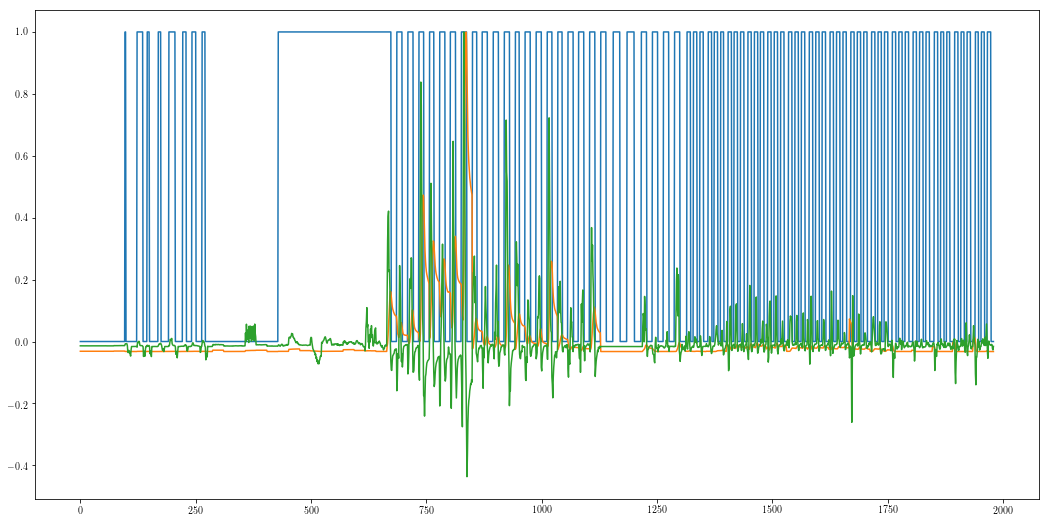

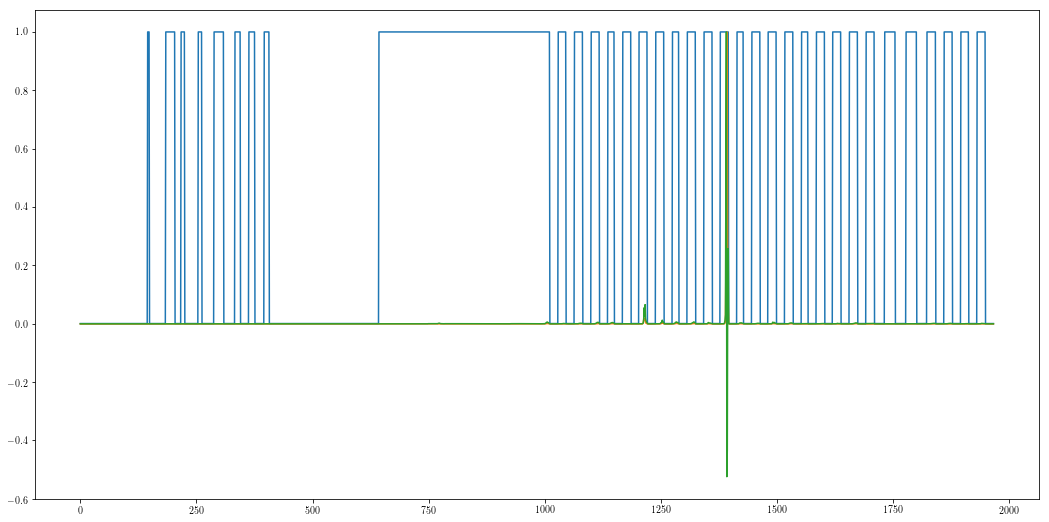

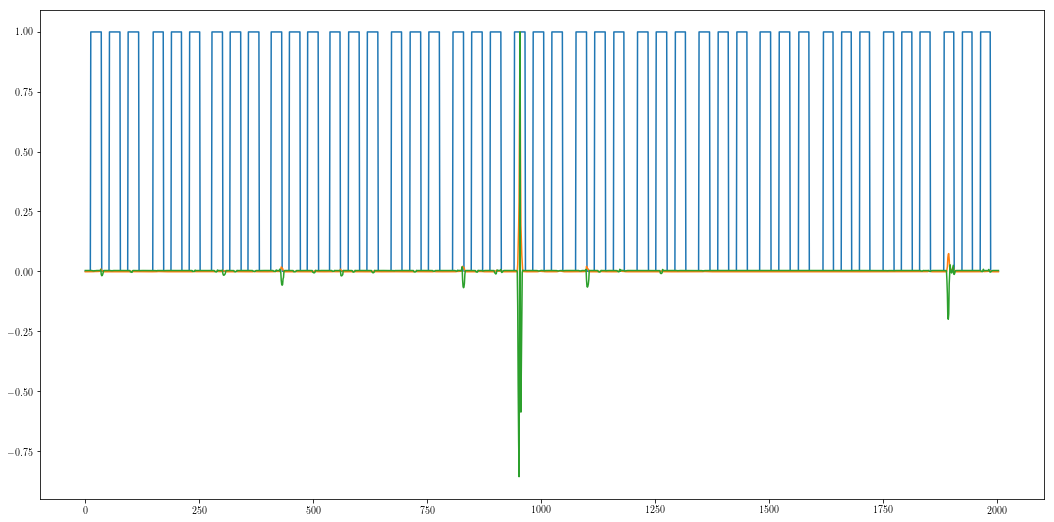

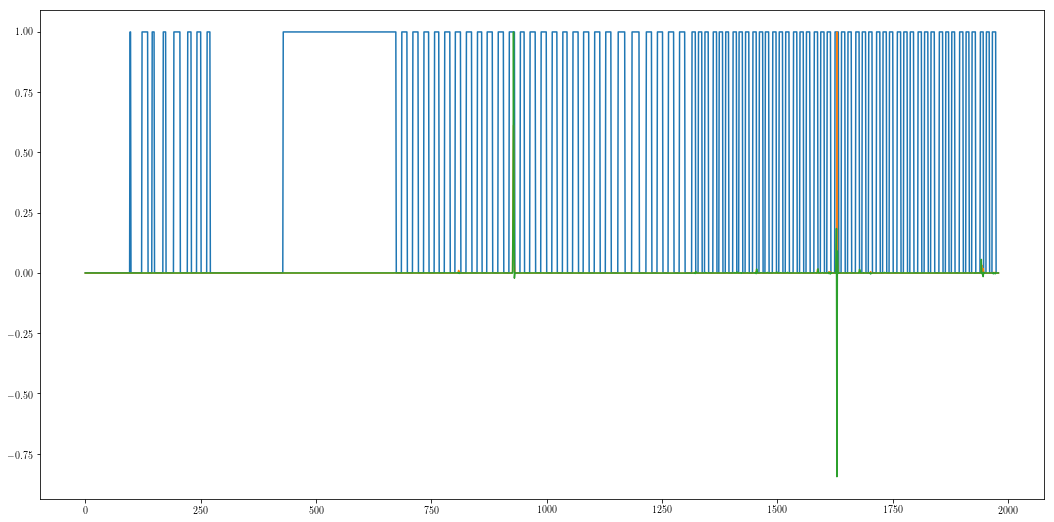

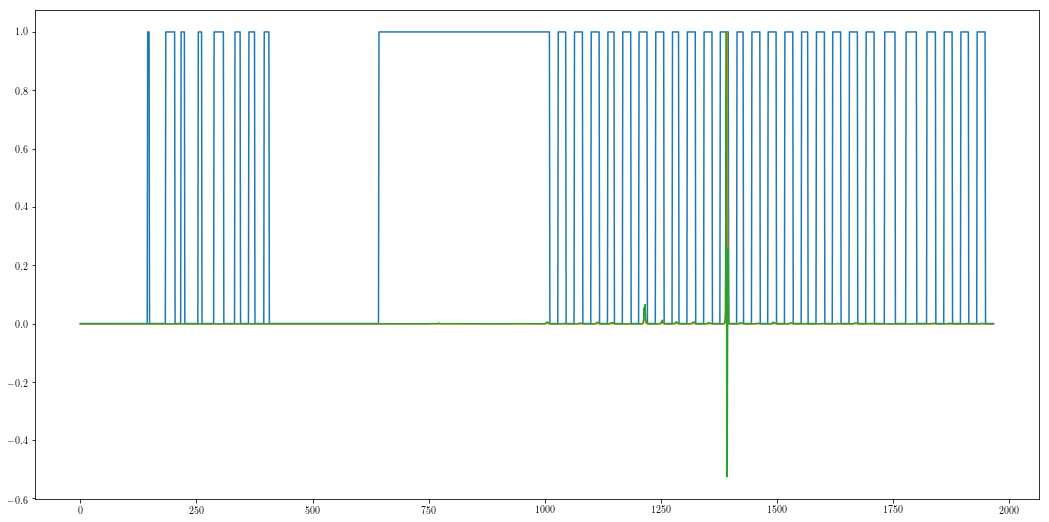

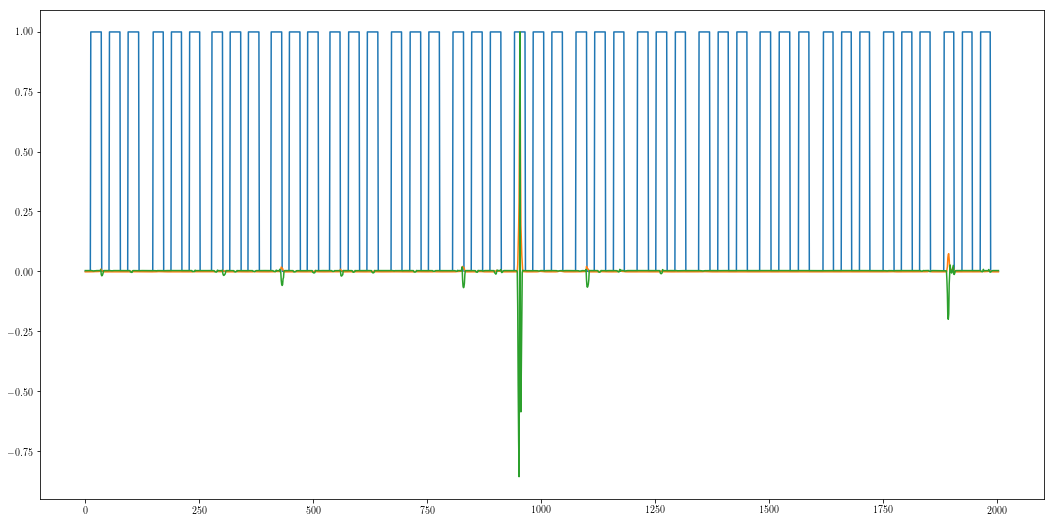

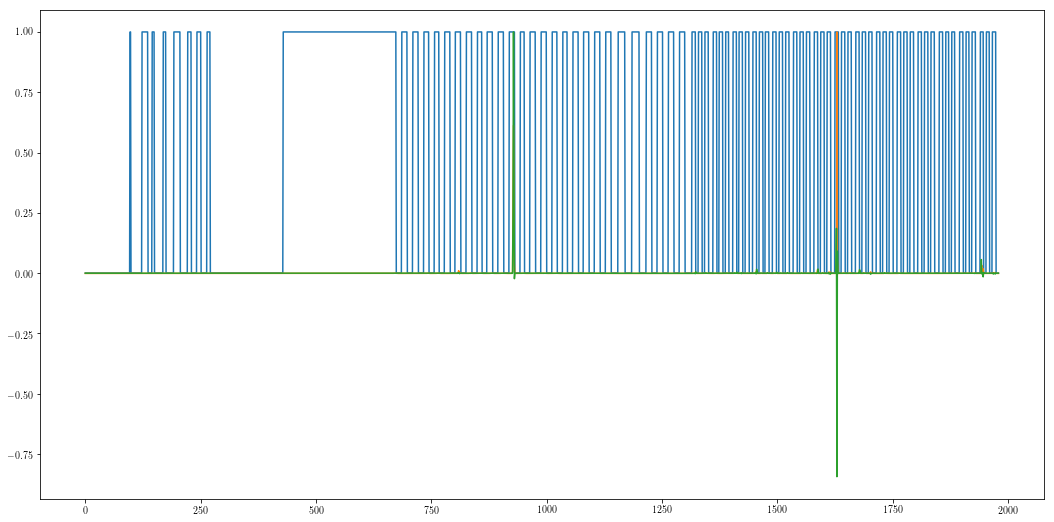

In [22]:
######################################## DATASETS PREPARATION ######################################################
datasets = [(Xpca[i][j],Y[i][tmpix[i]]) for j in range(c) for i in range(r)]
print np.array(datasets).shape
print "Dataset size and plots of 2 first X1 cols and Y1"
for ds in datasets:
    X1,Y1 = ds
    print X1.shape,Y1.shape
    plt.figure(figsize=(18,9))
    plt.plot(Y1)
    plt.hold
#     plt.plot(X1[:,:2])
    plt.plot(X1[:,:2]/np.max(X1[:,:2],axis=0))

xmin,xmax,ymin,ymax:  -13.5765985143 288.914750891 -8.79307960939 10.6191412045
NearNb
1 0.886912325286 0.895806861499 0.822136762408 0.0225381399386 0.844986580139 0.0117106556777 --secs: 2.09808349609e-05
RBFSVM1
2 0.767471410419 0.74332909784 0.733205143613 0.0163286295644 0.711597163802 0.0217592168734 --secs: 3.00407409668e-05
RBFSVM2
3 0.861499364676 0.851334180432 0.799270920963 0.00957259073523 0.76743981092 0.0210796006938 --secs: 3.50475311279e-05
NaiveBayes
4 0.649301143583 0.658195679797 0.647950967432 0.0240313179746 0.658093979089 0.0228049330885 --secs: 2.31266021729e-05
LDA
5 0.656925031766 0.748411689962 0.658077955374 0.0283593117695 0.74589592597 0.0197575623576 --secs: 2.21729278564e-05
QDA
6 0.653113087675 0.706480304956 0.646709129512 0.0191129977663 0.680975844249 0.0214949254046 --secs: 2.50339508057e-05
MLP1
7 0.759847522236 0.777636594663 0.758682850619 0.0392980510236 0.758570684613 0.0319974513139 --secs: 2.40802764893e-05
MLP2
8 0.767471410419 0.79415501906

/home/jagrio/.local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


50 0.531130876747 0.809402795426 0.569050194288 0.0400637292735 0.819476825702 0.028540645444 --secs: 2.09808349609e-05
QDA


/home/jagrio/.local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


51 0.731893265565 0.885641677255 0.827072066659 0.0282666623125 0.875399591395 0.0259454404569 --secs: 2.09808349609e-05
MLP1
52 0.842439644219 0.918678526048 0.884284741417 0.0176794957645 0.911036333774 0.0122015461304 --secs: 2.19345092773e-05
MLP2
53 0.876747141042 0.918678526048 0.884284741417 0.0176794957645 0.922437207066 0.0179103888334 --secs: 2.31266021729e-05
Lasso
(1180, 20) (1180, 8)


/home/jagrio/.local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


54 0.529860228717 0.730622617535 0.529860228717 0.0 0.730622617535 0.0 --secs: 2.40802764893e-05
Lin.Regr
55 0.531130876747 0.818297331639 0.531130876747 0.0 0.818297331639 0.0 --secs: 2.50339508057e-05
Log.Regr


/home/jagrio/.local/lib/python2.7/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


56 0.731893265565 0.827191867853 0.72177222289 0.0226622666765 0.813155470096 0.0212226136813 --secs: 3.00407409668e-05
Dec.Tree
57 0.917407878018 0.951715374841 0.89702359492 0.0139162667675 0.926322957978 0.0177348289695 --secs: 2.59876251221e-05
RandFor
58 0.912325285896 0.942820838628 0.89699154749 0.0224750183953 0.932596242439 0.0165703460621 --secs: 2.38418579102e-05
AdaBoost
59 0.907242693774 0.964421855146 0.905908744943 0.0150369440179 0.944045186877 0.0131238628701 --secs: 2.00271606445e-05
EnsembleMLP
60 0.937738246506 0.975857687421 0.923727116132 0.0115761776862 0.970780755518 0.00646605052994 --secs: 5.21067288507e-07
xmin,xmax,ymin,ymax:  -2.70373300239 962.155119326 -204.81352206 238.375427576
NearNb
61 0.912718204489 0.957605985037 0.859042687214 0.0183425719923 0.935154205242 0.0139802666888 --secs: 2.09808349609e-05
RBFSVM1
62 0.724438902743 0.774314214464 0.704389233954 0.0348462397364 0.735585472089 0.0317562828094 --secs: 4.79221343994e-05
RBFSVM2
63 0.7518703241

/home/jagrio/.local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:523: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


80 0.508838383838 0.709595959596 0.535419154526 0.0616791440152 0.742480694212 0.0193521054799 --secs: 2.28881835938e-05
QDA
81 0.564393939394 0.762626262626 0.59593185256 0.0370655256987 0.789212642306 0.0421699741652 --secs: 2.09808349609e-05
MLP1
82 0.837121212121 0.873737373737 0.810532600908 0.0498684237011 0.872462383568 0.0281634485762 --secs: 2.19345092773e-05
MLP2
83 0.776515151515 0.863636363636 0.806759016002 0.0434436920513 0.885136533715 0.0222200605455 --secs: 2.00271606445e-05
Lasso
(1188, 20) (1188, 9)
84 0.508838383838 0.691919191919 0.508838383838 0.0 0.691919191919 0.0 --secs: 2.40802764893e-05
Lin.Regr
85 0.508838383838 0.709595959596 0.508838383838 0.0 0.709595959596 0.0 --secs: 2.71797180176e-05
Log.Regr
86 0.679292929293 0.752525252525 0.675551309609 0.0261008617421 0.767717538413 0.0240230191977 --secs: 2.09808349609e-05
Dec.Tree
87 0.902777777778 0.933080808081 0.859899689515 0.0227597362334 0.885128572566 0.0203937616355 --secs: 2.50339508057e-05
RandFor
88 0.

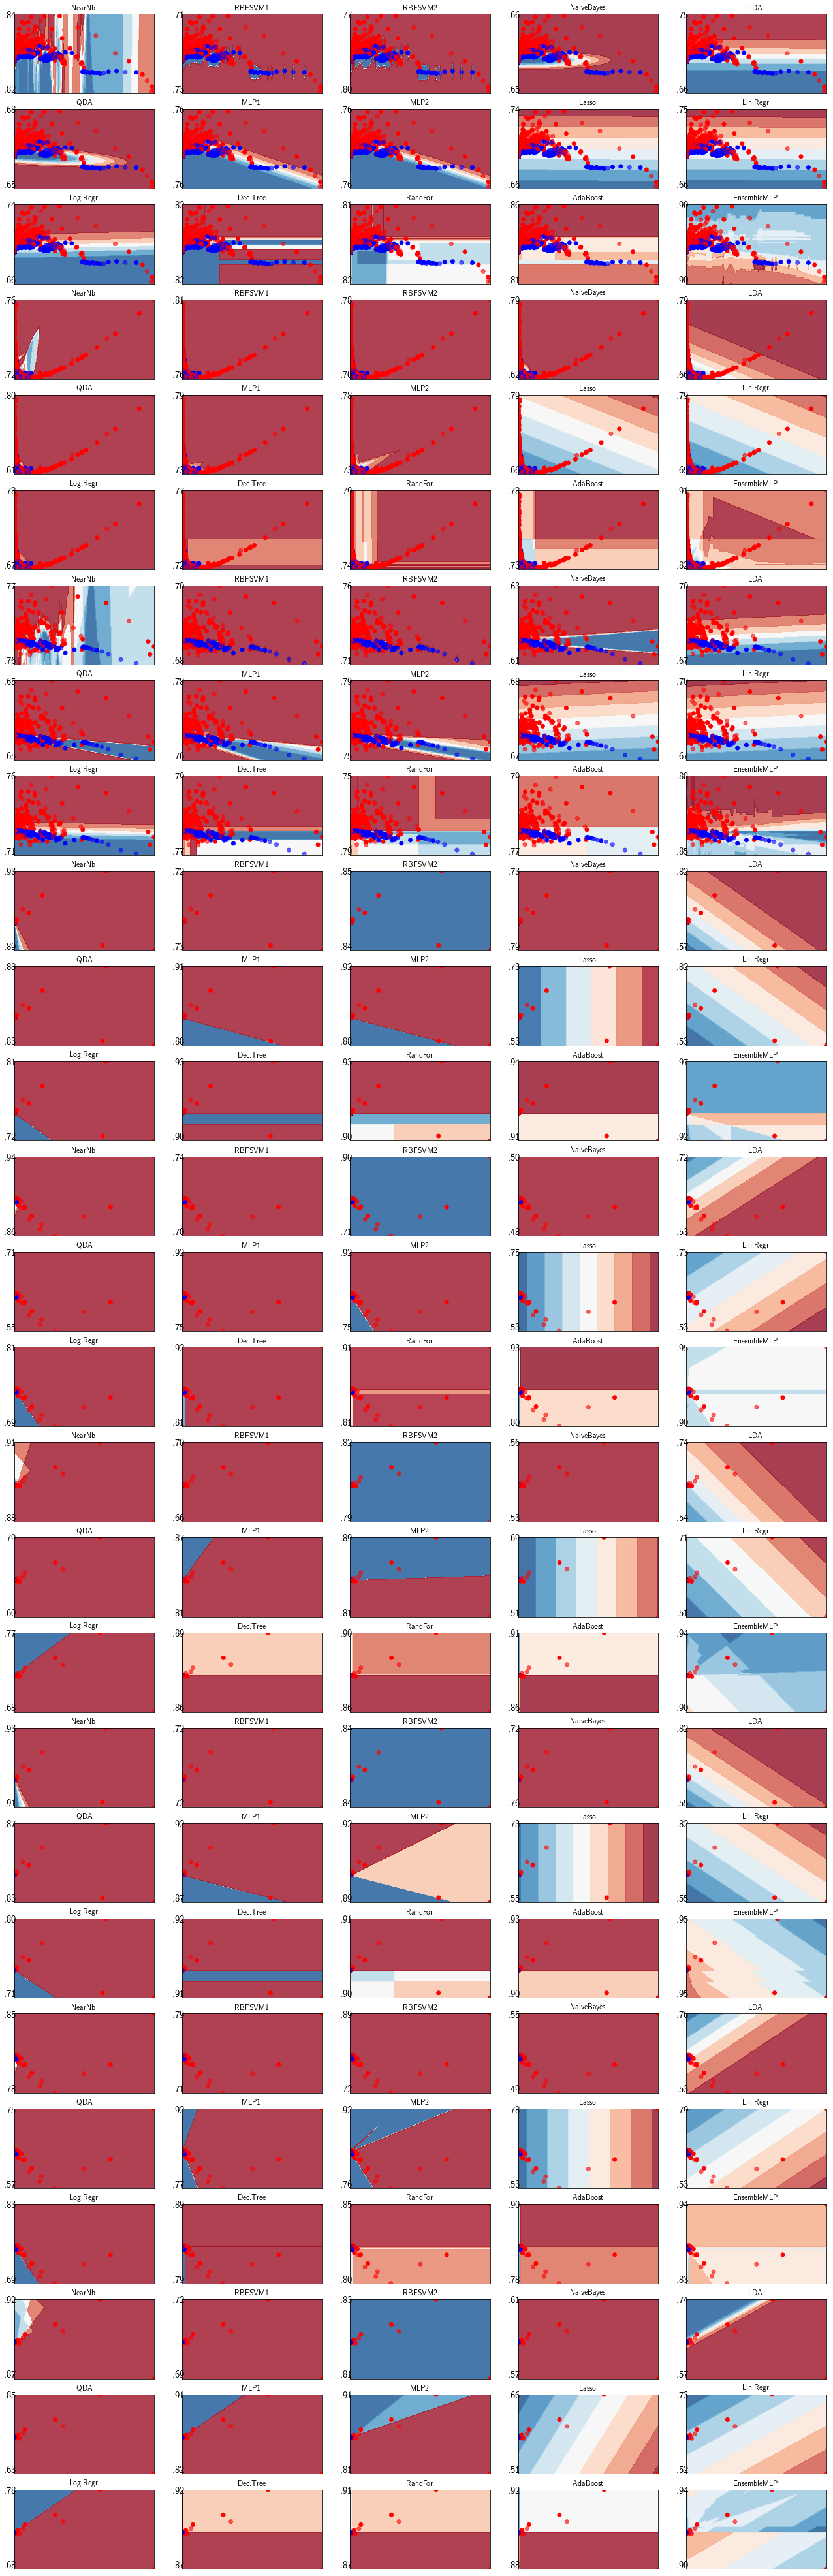

In [23]:
######################################### TRAINING OF ML CLASSIFIERS ###############################################
figure = plt.figure(figsize=(18, 72))
i = 1

#clffile = datapath+'trained_classifiers_'+str(window)+'_'+str(shift)+'.npz'
clffile = clfmodelfile
if os.path.isfile(clffile):
    clfall = np.load(clffile)['clfall']
    clfpall = np.load(clffile)['clfpall']
else:
    clfall = []
    clfpall = []
# iterate over datasets
start_time = time.time()
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    ncomp = 2
    # Keep the first ncomp of pca of X to visualize the results
    Xp = X[:,:ncomp]

    X_train, X_test, y_train, y_test, Xp_train, Xp_test = train_test_split(X, y, Xp, test_size=.4)
    
    x_min, x_max = Xp[:, 0].min() - .5, Xp[:, 0].max() + .5
    y_min, y_max = Xp[:, 1].min() - .5, Xp[:, 1].max() + .5
    print "xmin,xmax,ymin,ymax: ",x_min, x_max, y_min, y_max
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # just pick the colors used to represent the labels first
    cm = plt.cm.RdBu_r
    cm_bright = ListedColormap(['#0000FF', '#FF0000']) # blue:0 (stable), red: 1 (slip)
    
    clfmodels = []
    clfpmodels = []
    pred = []
    predp = []
    predts = []
    predpts = []
    score = []
    scorep = []
    scorec = []
    scorepc = []
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        tmpix = (i-1)%len(classifiers)
        ax = plt.subplot(len(datasets)*3, len(classifiers)/3., i)
        if os.path.isfile(clffile):
            clfp = clfpall[i-1]
        else:
            clfp = deepcopy(clf)
        if i%(len(names))!=0:
            if not os.path.isfile(clffile):
                print "Fitting... "
                clf.fit(X_train, y_train)
                clfp.fit(Xp_train,y_train)
#             if i%(len(names)) == 8: # LASSOCV
            print names[(i-1)%len(names)]
            if names[(i-1)%(len(names))] == "Lasso":
                if not os.path.isfile(clffile):
                    model = SelectFromModel(clf, prefit=True)
                else:
                    model = SelectFromModel(clfall[i-1], prefit=True)
                X_new = model.transform(X_train)
                print X_train.shape, X_new.shape
        else: # if classifier is ensemble mlp
            print names[(i-1)%len(names)]
            newX_train = np.array(pred).transpose()
            newXp_train = np.array(predp).transpose()
            if not os.path.isfile(clffile):
                print "Fitting... "
                clf.fit(newX_train,y_train)
                clfp.fit(newXp_train,y_train)
        if not os.path.isfile(clffile):
            clfmodels += [clf]
        else:
            clfmodels += [clfall[i-1]]
        clfpmodels += [clfp]
        if i%(len(names))!=0:
            if not os.path.isfile(clffile):
                npred = clf.predict(X_test)
            else:
                npred = clfall[i-1].predict(X_test)
            npredp = clfp.predict(Xp_test)
            t1 = time.time()
            score += [sum(((npred>0.5).astype(int)==y_test).astype(int))*1./len(y_test)]
            t2 = (time.time()-t1)
            scorep += [sum(((npredp>0.5).astype(int)==y_test).astype(int))*1./len(y_test)]
            try:
                if not os.path.isfile(clffile):
                    scorec += [cross_val_score(clf,X_test,y_test,cv=CV,scoring=metr)]
                else:
                    scorec += [cross_val_score(clfall[i-1],X_test,y_test,cv=CV,scoring=metr)]
                scorepc += [cross_val_score(clfp,Xp_test,y_test,cv=CV,scoring=metr)]
            except ValueError:
                scorec += [np.array(score[tmpix])]
                scorepc += [np.array([scorep[tmpix]])]      
            if not os.path.isfile(clffile):
                if hasattr(clf, "predict_proba"):
                    pred += [clf.predict_proba(X_train)[:,1]]
                    predts += [clf.predict_proba(X_test)[:,1]]
                else:
                    pred += [clf.predict(X_train)]
                    predts += [clf.predict(X_test)]
            else:
                if hasattr(clf, "predict_proba"):
                    pred += [clfall[i-1].predict_proba(X_train)[:,1]]
                    predts += [clfall[i-1].predict_proba(X_test)[:,1]]
                else:
                    pred += [clfall[i-1].predict(X_train)]
                    predts += [clfall[i-1].predict(X_test)]
            if hasattr(clfp, "predict_proba"):
                predp += [clfp.predict_proba(Xp_train)[:,1]]
                predpts += [clfp.predict_proba(Xp_test)[:,1]]
            else:
                predp += [clfp.predict(Xp_train)]
                predpts += [clfp.predict(Xp_test)]
        else: # if classifier is ensemble MLP
            newX_test = np.array(predts).transpose()
            newXp_test = np.array(predpts).transpose()
            t1 = time.time()
            if not os.path.isfile(clffile):
                score += [clf.score(newX_test, y_test)]
            else:
                score += [clfall[i-1].score(newX_test, y_test)]
            t2 = (time.time()-t1)*1./len(y_test)
            scorep += [clfp.score(newXp_test, y_test)]
            try:
                if not os.path.isfile(clffile):
                    scorec += [cross_val_score(clf,newX_test,y_test,cv=CV,scoring=metr)]
                else:
                    scorec += [cross_val_score(clfall[i-1],newX_test,y_test,cv=CV,scoring=metr)]
                scorepc += [cross_val_score(clfp,newXp_test,y_test,cv=CV,scoring=metr)]
            except ValueError:
                scorec += [np.array(score[tmpix])]
                scorepc += [np.array([scorep[tmpix]])]
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]*[y_min, y_max].
        Zlist = []
        if i%(len(names))!=0:
            if not hasattr(clfp, "predict_proba"):
                Z = clfp.predict(np.c_[xx.ravel(), yy.ravel()])
            else:
                try:
                    Z = clfp.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                except MemoryError:
                    print "Memory Error Handled!"
                    Z = clfp.predict(np.c_[xx.ravel(), yy.ravel()])
            Zlist += [Z]
        else: # if classifier is ensemble MLP
            Z = np.zeros((np.c_[xx.ravel(), yy.ravel()].shape[0]))
            j = 0
            for clfpi in clfpmodels:
                if j >= len(clfmodels)-1:
                    continue
                mult = (clfp.intercepts_[0][:,np.newaxis]*clfp.intercepts_[1]*clfp.intercepts_[2])[:,0]
                if not hasattr(clfpi, "predict_proba"):
                    #Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
                    #Z += clf.intercepts_[0][j]*clfpi.decision_function(np.c_[xx.ravel(), yy.ravel()])
                    #Z += clf.intercepts_[0][j]*clfpi.predict(np.c_[xx.ravel(), yy.ravel()])
                    Z += mult[j]*clfpi.predict(np.c_[xx.ravel(), yy.ravel()])
                else:
                    #Z += clf.intercepts_[0][j]*clfpi.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                    Z += mult[j]*clfpi.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                j += 1
                Zlist += [Z]
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(Xp_train[:, 0], Xp_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(Xp_test[:, 0], Xp_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.min()+0.02*(xx.max()-xx.min()), yy.max()-0.05*(yy.max()-yy.min()), ('%.2f' % scorec[tmpix].mean()).lstrip('0'),
                size=15, horizontalalignment='right')
        ax.text(xx.min()+0.02*(xx.max()-xx.min()), yy.min()+0.01*(yy.max()-yy.min()), ('%.2f' % scorepc[tmpix].mean()).lstrip('0'),
                size=15, horizontalalignment='right')
        print i, scorep[tmpix], score[tmpix], scorepc[tmpix].mean(), scorepc[tmpix].std(),\
               scorec[tmpix].mean(), scorec[tmpix].std() , '--secs:', t2
        i += 1
    if not os.path.isfile(clffile):
        clfall += deepcopy(clfmodels)
        clfpall += deepcopy(clfpmodels)
figure.subplots_adjust(left=.02, right=.98)
print("--- %s seconds ---" % (time.time() - start_time))
#plt.show()
savefig('plots/'+featname+'.png', bbox_inches='tight')

In [24]:
########################################## Saving/Loading ML Models ################################################
if not os.path.isfile(clffile):
    np.savez(clffile,clfall=np.array(clfall),clfpall=np.array(clfpall))
else:
    clfall = np.load(clffile)['clfall']
print np.array(clfall).shape

(135,)


In [25]:
################################# Saving STD, FEATSEL, PCA, ML Models for online usage #############################
modelfile = datapath+'allmodels_trans'+str(window)+'_'+str(shift)+'.npz'
if not os.path.isfile(modelfile):
    np.savez(modelfile,clfall=np.array(clfall),bestsel=bestix,stdtran=S,pca=pca)
else:
    clfall = np.load(modelfile)['clfall']
    bestsel = np.load(modelfile)['bestsel']
    stdtran = np.load(modelfile)['stdtran']
    pca = np.load(modelfile)['pca']
    print np.array(clfall).shape, bestsel.shape, stdtran.shape, pca.shape

(135,) (3, 3) (3, 3) (3, 3)


In [27]:
################################### Computing test inputs for validation ###########################################
ix = [[0,3,6],[1,4,7],[2,5,8]]
dsfile = featpath+featname+'_testds'+'.npz'
S = stdtran
bestix = bestsel
if os.path.isfile(dsfile):
    ds = np.load(dsfile)['ds']
else:
    ds = {}
    X = np.load(XYfile)['X']
    Y = np.load(XYfile)['Y']
    r = X.shape[0]
    c = 3
    tmpind = {}
    tmpind[2] = range(X[0].shape[1])
    tmpind[0] = range(X[0].shape[1]/2)
    tmpind[1] = range(X[0].shape[1]/2,X[0].shape[1])
    tmpind = np.array([i for _,i in tmpind.items()])
    rng = np.random.RandomState(2)
    X += 0.0 * rng.uniform(size=X.shape)
    for i in range(r): # for all datasets (take each scaler and pca)
        ds[i] = {} 
        for j in range(r): # for all datasets as well (transform all of them with the given scaler and pca)
            ds[i][j] = {}
            for k in range(c): # for all feature dimensions
                tmpnorm = S[i][k].transform(X[j][:,tmpind[k]])
                #Xfs[i][k] = np.array(featsel[i][k].transform(tmpnorm))[:,bestix[i][k][:nfeat]]
                tmpfs = np.array(tmpnorm)[:,bestix[i][k][:nfeat]]
                ds[i][j][k] = pca[i][k].transform(tmpfs) # transform with pca(i,k) all Xfs(j,k) 
                print i,j,k,tmpfs.shape,ds[i][j][k].shape,Y[j].shape,X[j][:,tmpind[k]].shape,tmpnorm.shape
    ds = np.array([[[dsijk for _,dsijk in dsij.items()] for _,dsij in dsi.items()] for _,dsi in ds.items()])
    np.savez(dsfile,ds=ds)
print ds.shape

0 0 0 (19665, 1000) (19665, 20) (19665,) (19665, 3108) (19665, 3108)
0 0 1 (19665, 1000) (19665, 20) (19665,) (19665, 3108) (19665, 3108)
0 0 2 (19665, 1000) (19665, 20) (19665,) (19665, 6216) (19665, 6216)
0 1 0 (20041, 1000) (20041, 20) (20041,) (20041, 3108) (20041, 3108)
0 1 1 (20041, 1000) (20041, 20) (20041,) (20041, 3108) (20041, 3108)
0 1 2 (20041, 1000) (20041, 20) (20041,) (20041, 6216) (20041, 6216)
0 2 0 (19791, 1000) (19791, 20) (19791,) (19791, 3108) (19791, 3108)
0 2 1 (19791, 1000) (19791, 20) (19791,) (19791, 3108) (19791, 3108)
0 2 2 (19791, 1000) (19791, 20) (19791,) (19791, 6216) (19791, 6216)
1 0 0 (19665, 1000) (19665, 20) (19665,) (19665, 3108) (19665, 3108)
1 0 1 (19665, 1000) (19665, 20) (19665,) (19665, 3108) (19665, 3108)
1 0 2 (19665, 1000) (19665, 20) (19665,) (19665, 6216) (19665, 6216)
1 1 0 (20041, 1000) (20041, 20) (20041,) (20041, 3108) (20041, 3108)
1 1 1 (20041, 1000) (20041, 20) (20041,) (20041, 3108) (20041, 3108)
1 1 2 (20041, 1000) (20041, 20) (2

In [28]:
################################### Computing test outputs for evaluation ##########################################
ftsnames = ['sf','ftn','all']
outfile = featpath+featname+'_testout_all'+'.npz'
if os.path.isfile(outfile):
    tmpout = np.load(outfile)['tmpout']
    tmpfsc = np.load(outfile)['tmpfsc']
    tmpauc = np.load(outfile)['tmpauc']
else: 
    tmpout = {}
    tmpfsc = {}
    tmpauc = {}
    tmppred = {}
    for i in range(r):
        tmpout[i] = {}
        tmppred[i] = {}
        tmpfsc[i] = {}
        tmpauc[i] = {}
        for j in range(r):
            tmpout[i][j] = {}
            tmpfsc[i][j] = {}
            tmpauc[i][j] = {}
            tmppred[i][j] = {}
            for k in range(c):
                tmpout[i][j][k] = {}
                tmppred[i][j][k] = {}
                tmpfsc[i][j][k] = {}
                tmpauc[i][j][k] = {}
                for l in range(len(names)):
                    if (l+1)%len(names)!=0: # not ensemble
                        tmpout[i][j][k][l] = clfall[ix[i][k]*len(names)+l].score(ds[i][j][k],Y[j])
                        tmppred[i][j][k][l] = clfall[ix[i][k]*len(names)+l].predict(ds[i][j][k])
                    else:
                        tmpin = np.array([tpred for _,tpred in tmppred[i][j][k].items()]).transpose()
                        tmpout[i][j][k][l] = clfall[ix[i][k]*len(names)+l].score(tmpin,Y[j])
                        tmppred[i][j][k][l] = clfall[ix[i][k]*len(names)+l].predict(tmpin)
                    tmpfsc[i][j][k][l] = f1_score(Y[j],np.round(np.divide(np.abs(tmppred[i][j][k][l]),np.finfo(float).eps+np.amax(np.abs(tmppred[i][j][k][l])))))
                    tmpauc[i][j][k][l] = roc_auc_score(Y[j],np.round(np.divide(np.abs(tmppred[i][j][k][l]),np.finfo(float).eps+np.amax(np.abs(tmppred[i][j][k][l])))))
                    print i,j,k,l,ds[i][j][k].shape,Y[j].shape,tmpout[i][j][k][l],tmpfsc[i][j][k][l],tmpauc[i][j][k][l]
    tmpout = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmpout.items()])
    tmppred = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmppred.items()])
    tmpfsc = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmpfsc.items()])
    tmpauc = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmpauc.items()])
    np.savez(outfile,tmpout=tmpout,tmppred=tmppred,tmpfsc=tmpfsc,tmpauc=tmpauc)
print tmpout[:,:,:,-1],tmpfsc[:,:,:,-1],tmpauc[:,:,:,-1]

0 0 0 0 (19665, 20) (19665,) 0.907144673277 0.900153105862 0.906231934339
0 0 0 1 (19665, 20) (19665,) 0.747520976354 0.721302273365 0.744554004577
0 0 0 2 (19665, 20) (19665,) 0.847342995169 0.818632189464 0.840834039332
0 0 0 3 (19665, 20) (19665,) 0.640579710145 0.474185389079 0.623677242195
0 0 0 4 (19665, 20) (19665,) 0.75021612001 0.70537428023 0.743719944897
0 0 0 5 (19665, 20) (19665,) 0.68817696415 0.554425228891 0.672441160113
0 0 0 6 (19665, 20) (19665,) 0.769336384439 0.747663551402 0.766948515028
0 0 0 7 (19665, 20) (19665,) 0.797304856344 0.773677038383 0.793893220552
0 0 0 8 (19665, 20) (19665,) 0.249254432881 0.0578277783619 0.514887397142
0 0 0 9 (19665, 20) (19665,) 0.273490898084 0.0237458551717 0.505913208376
0 0 0 10 (19665, 20) (19665,) 0.738316806509 0.691708602924 0.731838603137
0 0 0 11 (19665, 20) (19665,) 0.86468344775 0.846442379826 0.860644432246
0 0 0 12 (19665, 20) (19665,) 0.842817187897 0.826494527084 0.840202238229
0 0 0 13 (19665, 20) (19665,) 0.88375

In [29]:
################################### Computing stats for assessment #################################################
# mean of all test datasets, for each train dataset, for each ft, for each clf
meantsds = np.mean(tmpout,axis=1)
# mean of all test datasets, of all train datasets, for each ft, for each clf
meanft = np.mean(meantsds,axis=0)
# mean of all test datasets, of all ft, for each train dataset, for each clf
meantrds = np.mean(meantsds,axis=1)
# mean of all test datasets, of all train datasets, of all ft, for each clf
meanclf1 = np.mean(meanft,axis=0)
meanclf2 = np.mean(meantrds,axis=0)

print tmpout.shape, meantsds.shape, meanft.shape, meantrds.shape, meanclf1.shape, meanclf2.shape
print '--------------------------------------------------------------------------------------------','ALL'
print 'Best 5 Mean Accuracy of Classifiers for alltestds and alltrainds for each ft: '
maxmeanft = np.array([sorted(zip(map(lambda x: round(x,4), meanft[i,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True) for i in range(meantrds.shape[0])])
print maxmeanft[:,:5,:]
print 'Best 5 Mean Accuracy of Classifiers for alltestds and allft for each trainds: '
maxmeantrds = np.array([sorted(zip(map(lambda x: round(x,4), meantrds[i,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True) for i in range(meantrds.shape[0])])
print maxmeantrds[:,:5,:]
print 'Best 5 Mean Accuracy of Classifiers for alltrainds, alltestds and allft: '
maxmeanclf1 = sorted(zip(map(lambda x: round(x,4), meanclf1),map(lambda x: x[:4], names),range(len(names))),reverse=True)
print maxmeanclf1[:5]
print '--------------------------------------------------------------------------------------------','MaxMeanAll'
for i in range(meantsds.shape[0]):
    for j in range(meantsds.shape[1]):
        print 'Best 5 Mean Accuracy of Classifiers for trainds['+str([i,j])+'], testds['+str([i,j])+'] and ft['+str([i,j])+'] (version with all): '
        maxclf1 = sorted(zip(map(lambda x: round(x,4), meantsds[i,j,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True)
        print maxclf1[:5]
print '--------------------------------------------------------------------------------------------','MaxMeanSelf'
for i in range(tmpout.shape[0]):
    for j in range(tmpout.shape[2]):
        print 'Best 5 Self Accuracy of Classifiers for tmpout['+str([i,i,j])+']: '
        maxclf = sorted(zip(map(lambda x: round(x,4), tmpout[i,i,j,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True)
        print maxclf[:5]
print '--------------------------------------------------------------------------------------------','MaxMeanCross'
for i in range(tmpout.shape[0]):
    for j in range(tmpout.shape[1]):
        for k in range(tmpout.shape[2]):
            if i!=j:
                print 'Best 5 Mean Cross Accuracy of Classifiers for tmpout['+str([i,j,k])+']: '
                maxclf = sorted(zip(map(lambda x: round(x,4), tmpout[i,j,k,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True)
                print maxclf[:5]
print '--------------------------------------------------------------------------------------------','EACH'
for i in range(len(names)):
    print '--------------------------------------------------------------------------------------------',i
    print 'Accuracy of '+str(names[i])+' in classifying (trainds,testds,ft): '
    print tmpout[:,:,:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltestds for each trainds and each ft: '
    print meantsds[:,:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltestds and alltrainds for each ft: '
    print meanft[:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltestds and allft for each trainds: '
    print meantrds[:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltrainds, alltestds and allft: '
    print meanclf1[i],' or mean(', tmpout[-1,:,-1,i],') = ',meantsds[-1,-1,i]

(3, 3, 3, 15) (3, 3, 15) (3, 15) (3, 15) (15,) (15,)
-------------------------------------------------------------------------------------------- ALL
Best 5 Mean Accuracy of Classifiers for alltestds and alltrainds for each ft: 
[[['0.7646' 'Ense' '14']
  ['0.7611' 'Dec.' '11']
  ['0.7523' 'Near' '0']
  ['0.7417' 'AdaB' '13']
  ['0.7352' 'Log.' '10']]

 [['0.9205' 'Near' '0']
  ['0.9171' 'AdaB' '13']
  ['0.9103' 'Ense' '14']
  ['0.9056' 'Dec.' '11']
  ['0.9042' 'Rand' '12']]

 [['0.8874' 'AdaB' '13']
  ['0.876' 'Near' '0']
  ['0.8733' 'MLP2' '7']
  ['0.8729' 'MLP1' '6']
  ['0.8696' 'Dec.' '11']]]
Best 5 Mean Accuracy of Classifiers for alltestds and allft for each trainds: 
[[['0.8669' 'AdaB' '13']
  ['0.8561' 'Near' '0']
  ['0.8549' 'Rand' '12']
  ['0.8406' 'Ense' '14']
  ['0.8397' 'Dec.' '11']]

 [['0.8356' 'MLP1' '6']
  ['0.8315' 'MLP2' '7']
  ['0.8229' 'Ense' '14']
  ['0.8208' 'RBFS' '2']
  ['0.8148' 'Dec.' '11']]

 [['0.892' 'Near' '0']
  ['0.8819' 'Dec.' '11']
  ['0.8787' 'AdaB' 

(50,) (50,)
(135,) (3, 3) (3, 3) (3, 3)
0 (727,) (727, 3108, 2)
(727,)
1 (727,) (727, 3108, 2)
(727,)
2 (726,) (726, 3108, 2)
(726,)
3 (720,) (720, 3108, 2)
(720,)
4 (763,) (763, 3108, 2)
(763,)
5 (672,) (672, 3108, 2)
(672,)
6 (733,) (733, 3108, 2)
(733,)
7 (687,) (687, 3108, 2)
(687,)
8 (748,) (748, 3108, 2)
(748,)
9 (691,) (691, 3108, 2)
(691,)
10 (725,) (725, 3108, 2)
(725,)
11 (675,) (675, 3108, 2)
(675,)
12 (708,) (708, 3108, 2)
(708,)
13 (708,) (708, 3108, 2)
(708,)
14 (708,) (708, 3108, 2)
(708,)
15 (708,) (708, 3108, 2)
(708,)
16 (708,) (708, 3108, 2)
(708,)
17 (708,) (708, 3108, 2)
(708,)
18 (708,) (708, 3108, 2)
(708,)
19 (708,) (708, 3108, 2)
(708,)
20 (708,) (708, 3108, 2)
(708,)
21 (708,) (708, 3108, 2)
(708,)
22 (708,) (708, 3108, 2)
(708,)
23 (708,) (708, 3108, 2)
(708,)
24 (708,) (708, 3108, 2)
(708,)
25 (708,) (708, 3108, 2)
(708,)
26 (708,) (708, 3108, 2)
(708,)
27 (708,) (708, 3108, 2)
(708,)
28 (2784,) (2784, 3108, 2)
(2784,)
29 (2783,) (2783, 3108, 2)
(2783,)
30 (

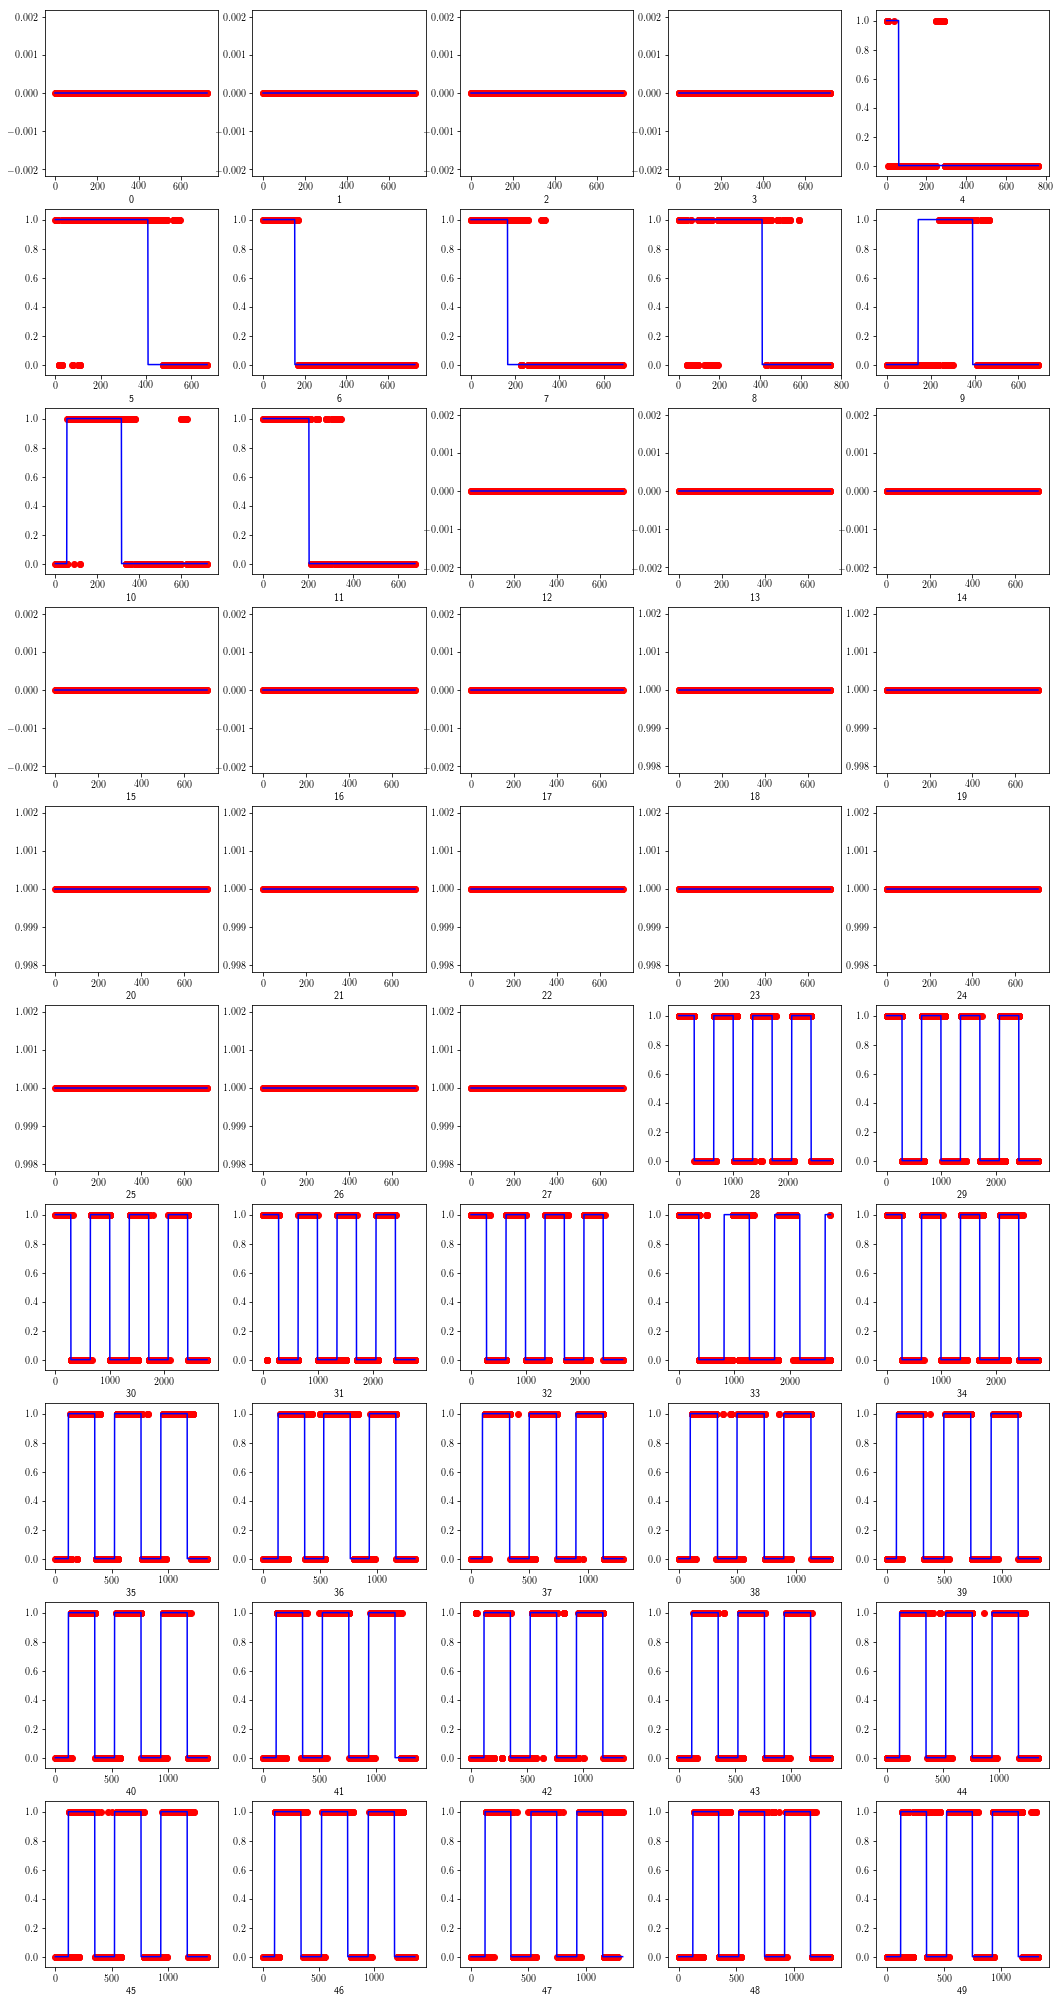

In [62]:
testfeat = np.load(featfile)['features']
testlabs = np.load(featfile)['labels']
print testfeat.shape, testlabs.shape
clfall = np.load(modelfile)['clfall']
bestsel = np.load(modelfile)['bestsel']
stdtran = np.load(modelfile)['stdtran']
pca = np.load(modelfile)['pca']
print np.array(clfall).shape, bestsel.shape, stdtran.shape, pca.shape
k = 8# keep k-th family of clfs, corresponding to clf[k1l(k),k2l(k)]
k1l = [0, 0 ,0, 1, 1, 1, 2, 2, 2]
k2l = [0, 1, 2, 0, 1, 2, 0, 1, 2]
kst1 = [0, 1, 0]
kst2 = [1, 2, 2]
k1, k2 = k1l[k], k2l[k]
# clf2use = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
clf2use = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
keepkbest = 1000 # features to keep for pca
allout = []
fig = plt.figure(figsize=(18,36))
r=10
for ix in range(testfeat.shape[0]):
    print ix, testlabs[ix].shape, testfeat[ix].shape
    output = []
    for tfix in range(testfeat[ix].shape[0]):
        feats = np.array(testfeat[ix][tfix,:,kst1[k2]:kst2[k2]]).flatten(order='F')[np.newaxis,:]
        rng = np.random.RandomState(2)
        feats += 0.0 * rng.uniform(size=feats.shape)
        #print 'feats: ', feats.shape
        #raw_input()
        stdfeats = stdtran[k1,k2].transform(feats)
        #print 'stdtr: ', stdfeats.shape
        bestfeats = stdfeats[:,bestsel[k1,k2][:keepkbest]]
        #print 'bestf: ', bestfeats.shape
        pcafeats = pca[k1,k2].transform(bestfeats)
        #print 'pcatr: ', pcafeats.shape

        # Use trained classifiers for prediction
        acc = []
        clfout = []
        for i in range(len(names)):
            if clf2use[i] != 1 and clf2use[-1] != 1:
                continue
            clf = clfall[len(names)*k+i]
            if (i+1)%(len(names)) != 0:
                if hasattr(clf, "predict_proba"):
                    acc += [clf.predict_proba(pcafeats)[0,1]]
                else:
                    acc += [clf.predict(pcafeats)[0]]
            else:
                tmpclfin = np.array(clfout)[np.newaxis,:]
                acc += [clf.predict_proba(tmpclfin)[0,1]]
            clfout += [int(acc[-1]>0.5)]

        weights = np.ones(np.array(acc).shape)
        if clf2use[-1] == 0: # majority vote decision
            output.append(int(sum(weights*np.array(acc))>sum(weights)/2))
        else: # ensemble MLP decision
            output.append(acc[-1])
    print np.array(output).shape
    allout.append(output)
    ax = fig.add_subplot(r,testfeat.shape[0]/r,ix+1)
    ax.plot(testlabs[ix],'b')
    ax.scatter(range(len(output)),output,color='r')
    ax.set_xlabel(str(ix))
print np.array(allout).shape

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

print classification_report(testlabs[ix],output)
cm = confusion_matrix(testlabs[ix],output)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm

             precision    recall  f1-score   support

        0.0       0.83      0.81      0.82       648
        1.0       0.82      0.84      0.83       675

avg / total       0.83      0.83      0.83      1323

[[ 0.80864198  0.19135802]
 [ 0.15555556  0.84444444]]
